# Tratamiento del dataframe 
Se ha extraido de a base de datos un daframe en formato pickle

## Imports

In [8]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sql_face.tables import *
import os


## Leer dataframe del disco
se especifica directorio y fichero

In [9]:
home = os.path.expanduser("~")

input_dir = os.path.join(home, 'video_resources', 'sql_database')
df = pd.read_pickle(os.path.join(input_dir,'df.pkl'))


In [10]:
df

,identity,pitch,angle_pitch,yaw,angle_yaw,roll,angle_roll,source,gender,headgear,...,type,beard,emotion,other_occlusions,race,image_id,Detector,E_Model,Q_model,Q_group
0,2011-1-unknown,Pitch.FRONTAL,NaN,Yaw.FRONTAL,NaN,Roll.FRONTAL,NaN,ENFSI,Gender.MALE,False,...,enfsiImage,False,Emotion.NEUTRAL,False,Race.WHITE,1,mtcnn,ArcFace,ser_fiq,QualityGroup.HIGH
1,2011-1,Pitch.FRONTAL,NaN,Yaw.FRONTAL,NaN,Roll.FRONTAL,NaN,ENFSI,Gender.MALE,False,...,enfsiImage,False,Emotion.FEAR,False,Race.LATINO,2,mtcnn,ArcFace,ser_fiq,QualityGroup.VERY_HIGH
2,2011-2-unknown,Pitch.FRONTAL,NaN,Yaw.FRONTAL,NaN,Roll.FRONTAL,NaN,ENFSI,Gender.MALE,False,...,enfsiImage,True,Emotion.NEUTRAL,False,Race.WHITE,3,mtcnn,ArcFace,ser_fiq,QualityGroup.MEDIUM
3,2011-2,Pitch.FRONTAL,NaN,Yaw.FRONTAL,NaN,Roll.HALF_LEANING,NaN,ENFSI,Gender.MALE,False,...,enfsiImage,False,Emotion.SAD,False,Race.ASIAN,4,mtcnn,ArcFace,ser_fiq,QualityGroup.HIGH
4,2011-3,Pitch.FRONTAL,NaN,Yaw.FRONTAL,NaN,Roll.FRONTAL,NaN,ENFSI,Gender.MALE,False,...,enfsiImage,False,Emotion.SAD,False,Race.WHITE,5,mtcnn,ArcFace,ser_fiq,QualityGroup.LOW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1791416,0001,None,NaN,None,NaN,None,NaN,ChokePoint,Gender.MALE,None,...,cpVideoFrame,None,Emotion.NEUTRAL,None,None,133930,mtcnn_serfiq,QMagFace,ser_fiq,QualityGroup.HIGH
1791417,0001,None,NaN,None,NaN,None,NaN,ChokePoint,Gender.MALE,None,...,cpVideoFrame,None,Emotion.NEUTRAL,None,None,133931,mtcnn_serfiq,QMagFace,ser_fiq,QualityGroup.HIGH
1791418,0001,None,NaN,None,NaN,None,NaN,ChokePoint,Gender.MALE,None,...,cpVideoFrame,None,Emotion.SAD,None,None,133932,mtcnn_serfiq,QMagFace,ser_fiq,QualityGroup.HIGH
1791419,0001,None,NaN,None,NaN,None,NaN,ChokePoint,Gender.MALE,None,...,cpVideoFrame,None,Emotion.NEUTRAL,None,None,133933,mtcnn_serfiq,QMagFace,ser_fiq,QualityGroup.MEDIUM


In [11]:
np.unique(df.source)

array(['ChokePoint', 'ENFSI', 'ForenFace', 'LFW', 'SCFace', 'UTKface',
       'XQLFW'], dtype=object)

In [12]:
np.unique(df.type)

array(['cpVideoFrame', 'enfsiImage', 'enfsiVideoFrame', 'image',
       'scImage'], dtype=object)

In [13]:
df.columns

Index(['identity', 'pitch', 'angle_pitch', 'yaw', 'angle_yaw', 'roll',
       'angle_roll', 'source', 'gender', 'headgear', 'age', 'age_number',
       'glasses', 'type', 'beard', 'emotion', 'other_occlusions', 'race',
       'image_id', 'Detector', 'E_Model', 'Q_model', 'Q_group'],
      dtype='object')

In [14]:
df2 = df.loc[df['type'] == 'enfsiImage']
df2.drop('E_Model', axis = 1,inplace = True)
df2 = df2.reset_index(drop=True)
len(df2)


16370

In [15]:
df2 = df2.drop_duplicates(subset = ['image_id','Detector','Q_model','Q_group'])

In [16]:

from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    r_corr = r - ((r - 1) ** 2) / (n - 1)
    k_corr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2_corr / min((k_corr - 1), (r_corr - 1)))

In [17]:
df2.Q_group


0            QualityGroup.HIGH
1       QualityGroup.VERY_HIGH
2          QualityGroup.MEDIUM
3            QualityGroup.HIGH
4             QualityGroup.LOW
                 ...          
4906          QualityGroup.LOW
4907          QualityGroup.LOW
4908       QualityGroup.MEDIUM
4909          QualityGroup.LOW
4910     QualityGroup.VERY_LOW
Name: Q_group, Length: 3274, dtype: object

In [18]:

#convertimos a String los Enum
variables = ['Q_group','gender','yaw','pitch','roll','emotion','race']
for var in variables:
    df2[var] = df2[var].apply(lambda x: x.value if x else None)


variables += ['Detector', 'Q_model']
df_plot = df2[variables]


In [19]:


# Calcular el coeficiente de Cramér V para cada par de variables
for i, var1 in enumerate(variables):
    for j, var2 in enumerate(variables):
        if i < j:
            coef = cramers_v(df_plot[var1], df_plot[var2])
            print(f"Coeficiente de Cramér V entre {var1} y {var2}: {coef}")

Coeficiente de Cramér V entre Q_group y gender: 0.047488324916182004
Coeficiente de Cramér V entre Q_group y yaw: 0.225403007660682
Coeficiente de Cramér V entre Q_group y pitch: 0.11875897201755473
Coeficiente de Cramér V entre Q_group y roll: 0.15741446761045683
Coeficiente de Cramér V entre Q_group y emotion: 0.08063084136977312
Coeficiente de Cramér V entre Q_group y race: 0.08505682470010642
Coeficiente de Cramér V entre Q_group y Detector: 0.5071923644544581
Coeficiente de Cramér V entre Q_group y Q_model: 0.16534166374120238
Coeficiente de Cramér V entre gender y yaw: 0.11476015467492014
Coeficiente de Cramér V entre gender y pitch: 0.13095855424344263
Coeficiente de Cramér V entre gender y roll: 0.01790366856173491
Coeficiente de Cramér V entre gender y emotion: 0.13535928062321803
Coeficiente de Cramér V entre gender y race: 0.1356487544368129
Coeficiente de Cramér V entre gender y Detector: 0.0
Coeficiente de Cramér V entre gender y Q_model: 0.0
Coeficiente de Cramér V entre 

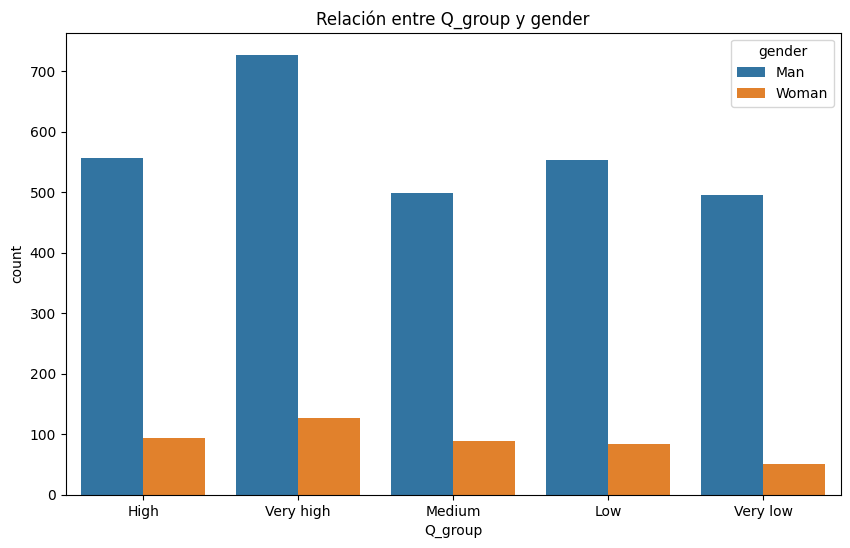

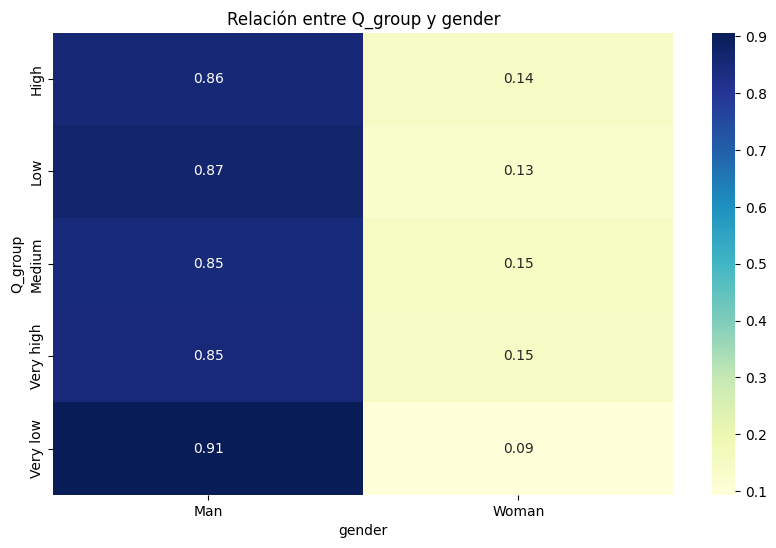

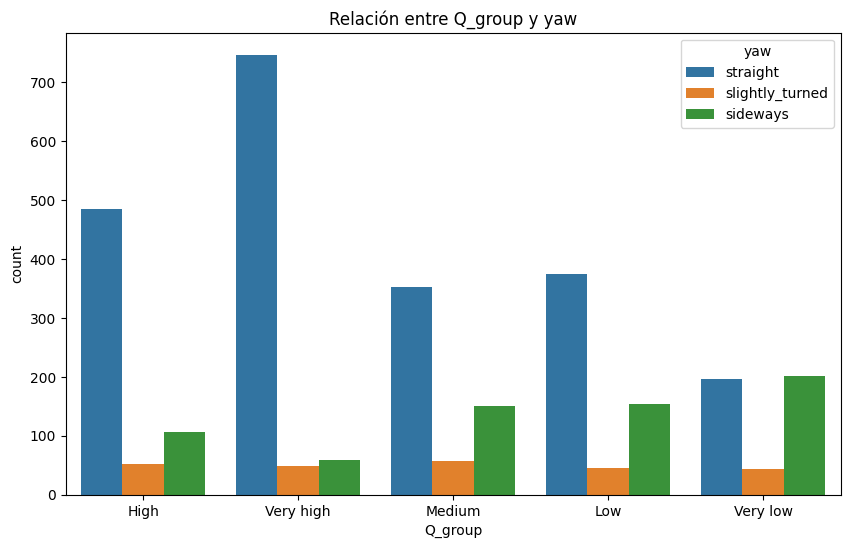

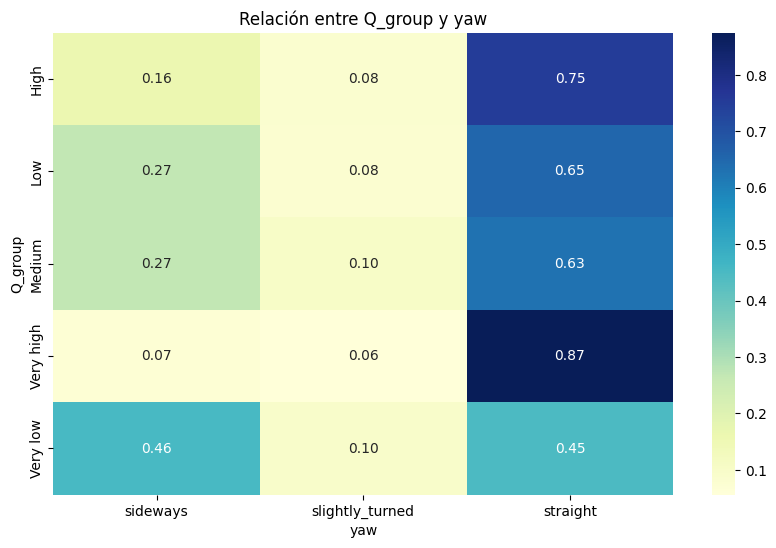

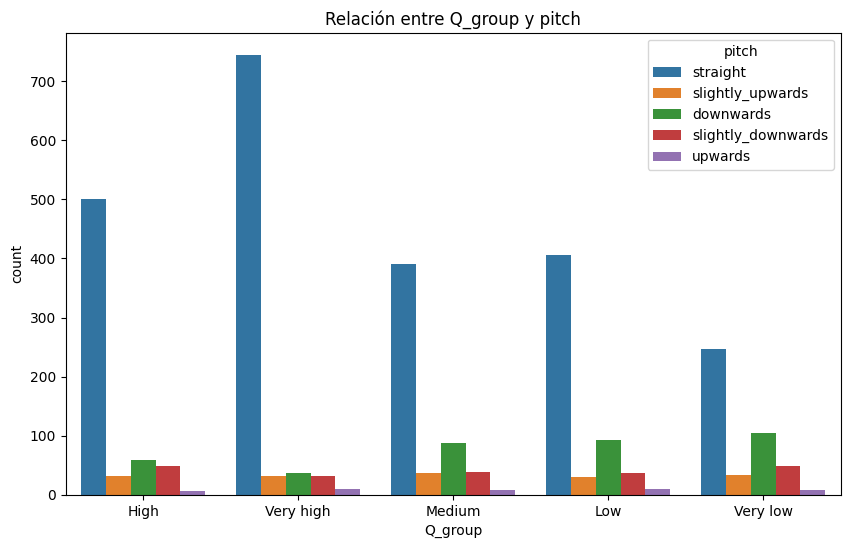

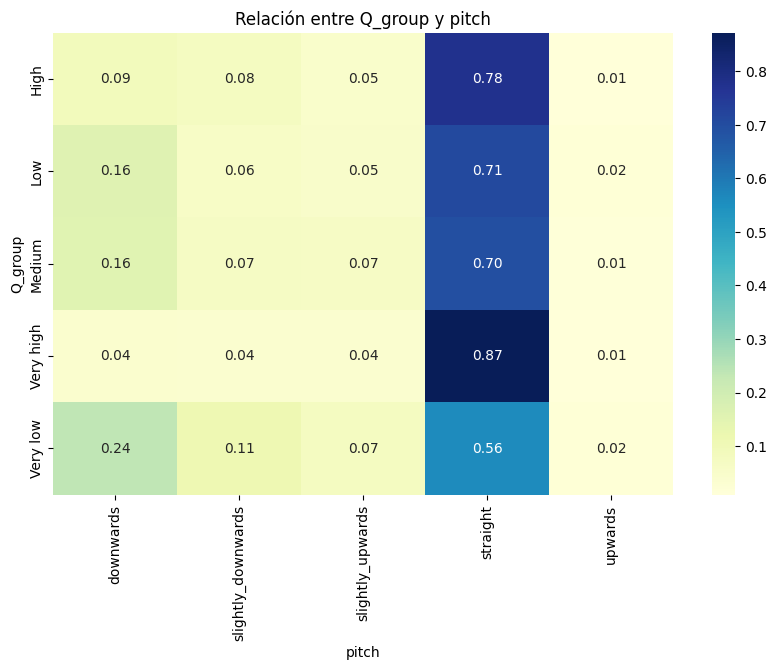

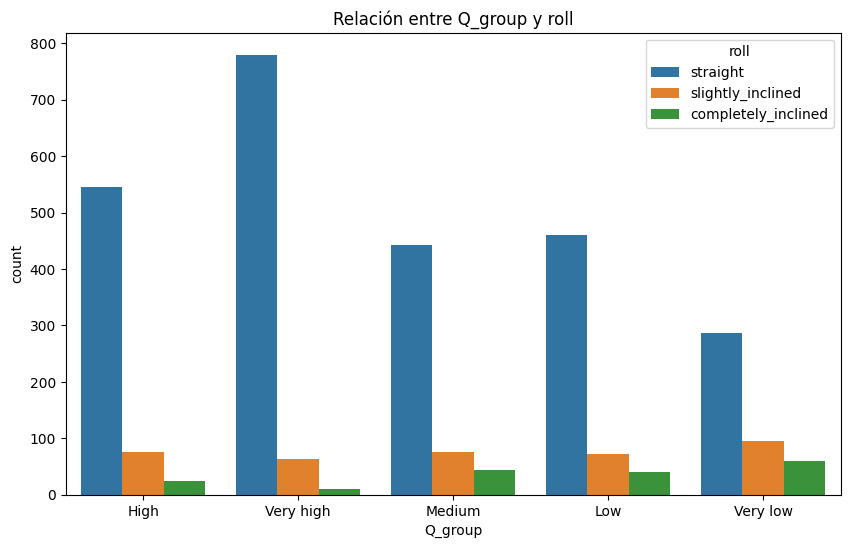

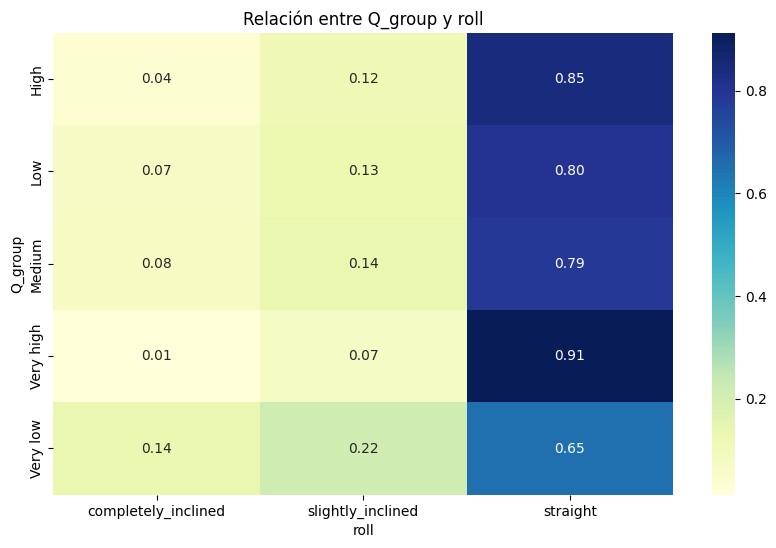

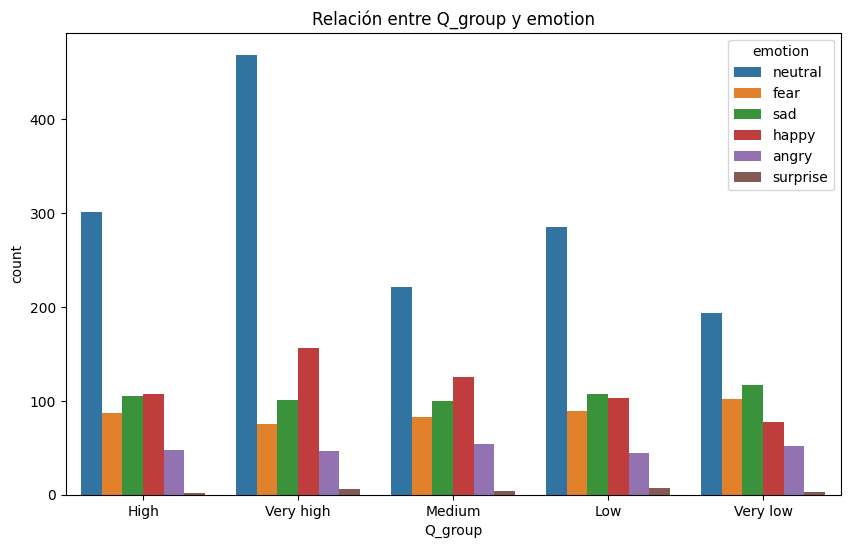

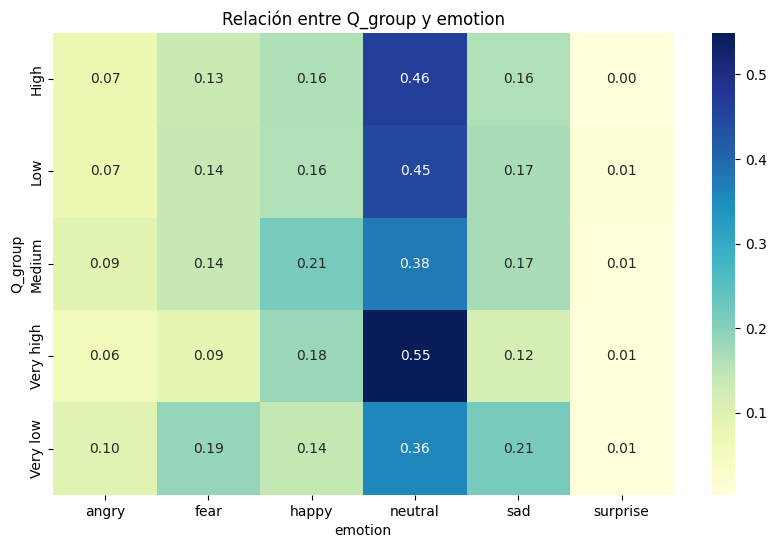

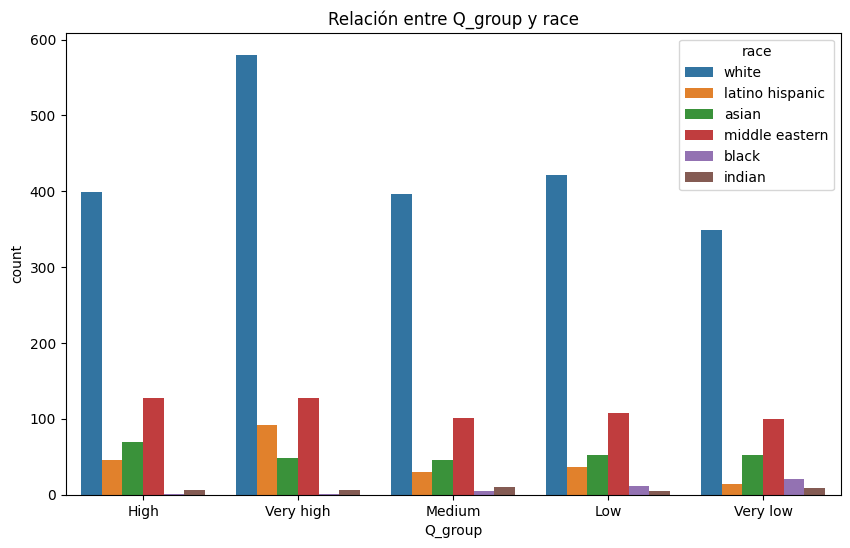

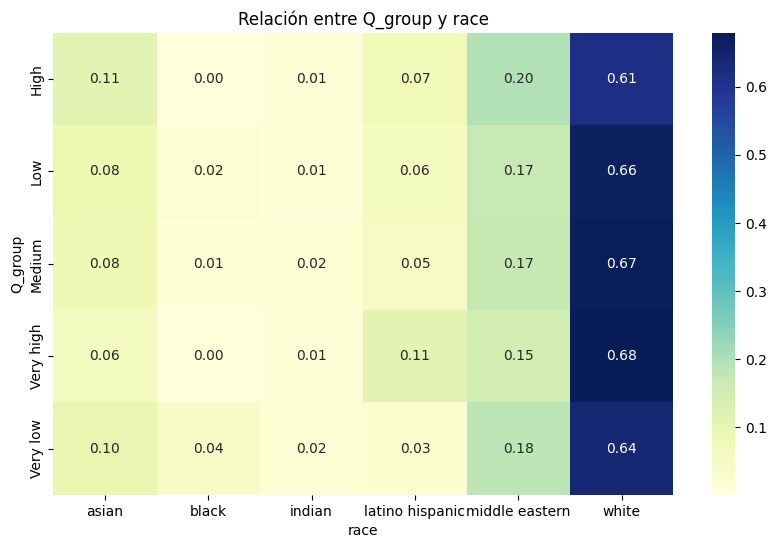

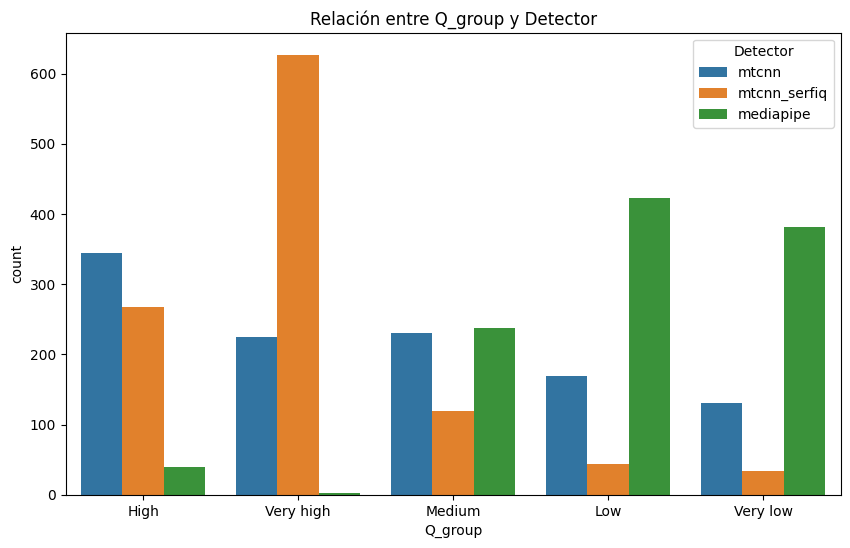

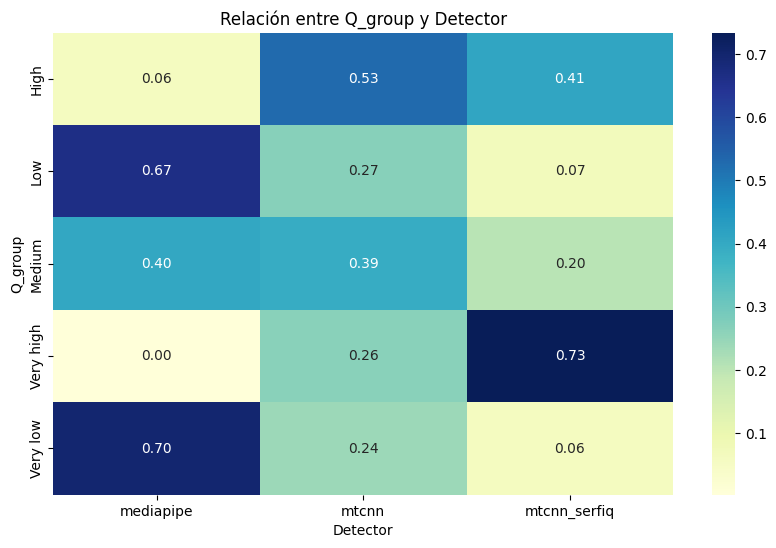

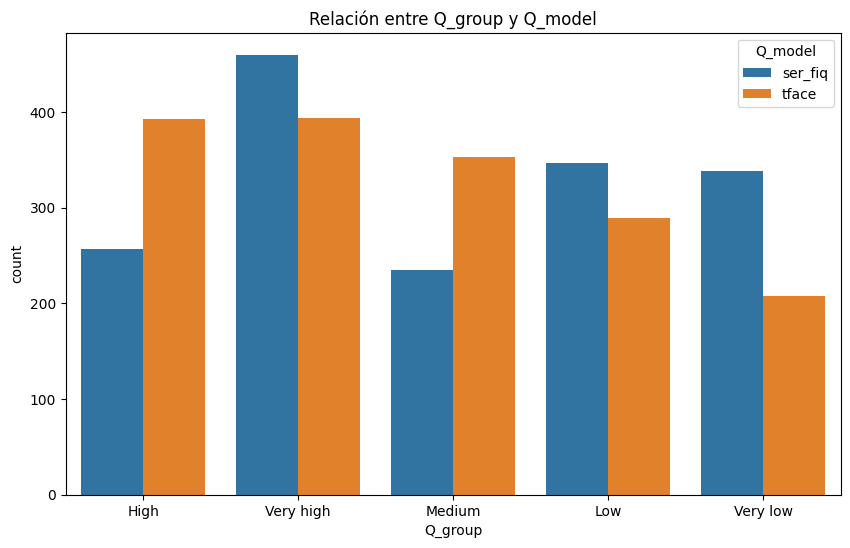

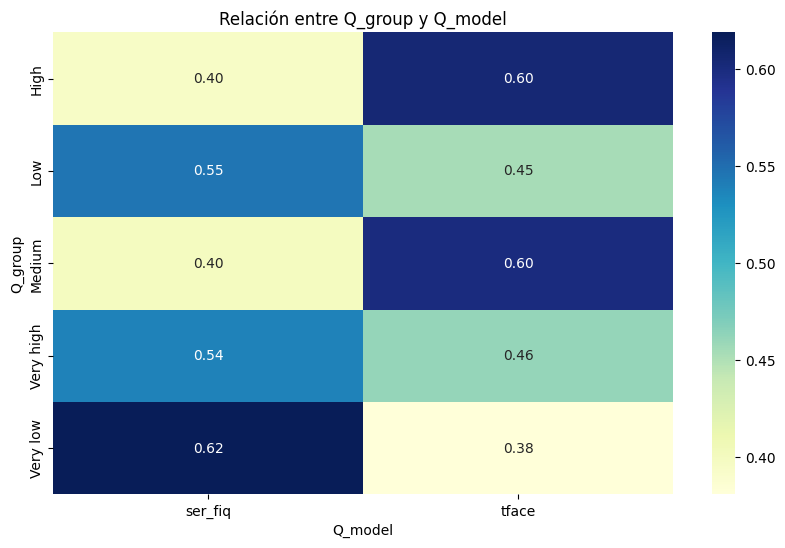

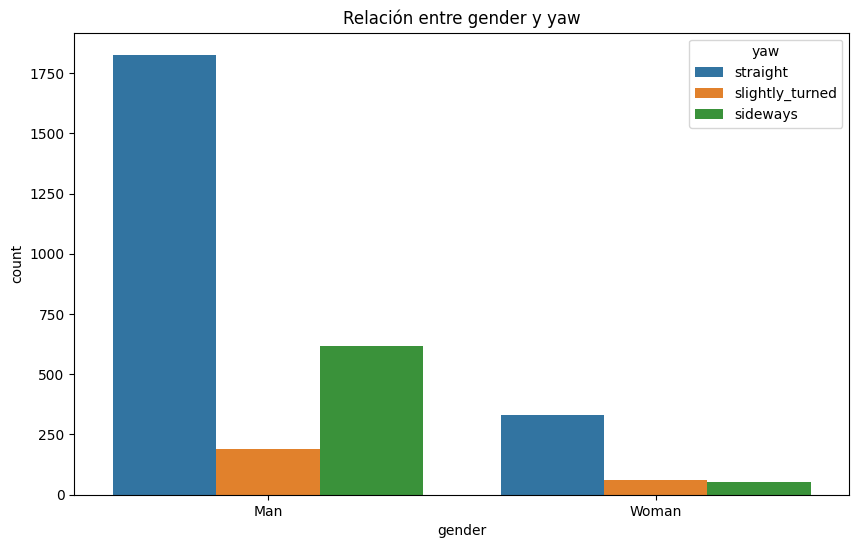

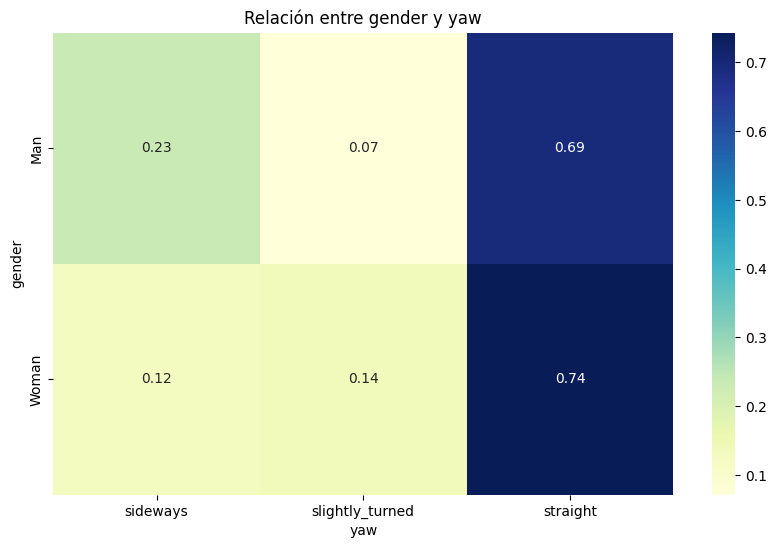

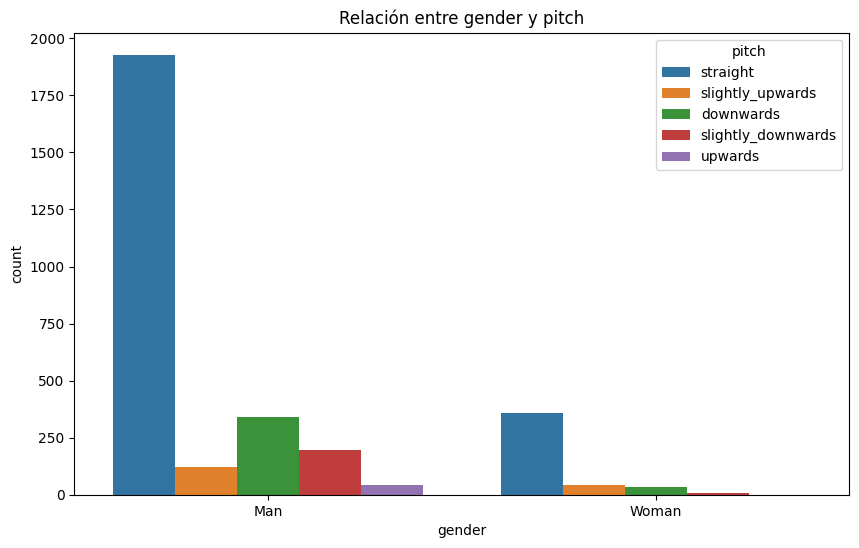

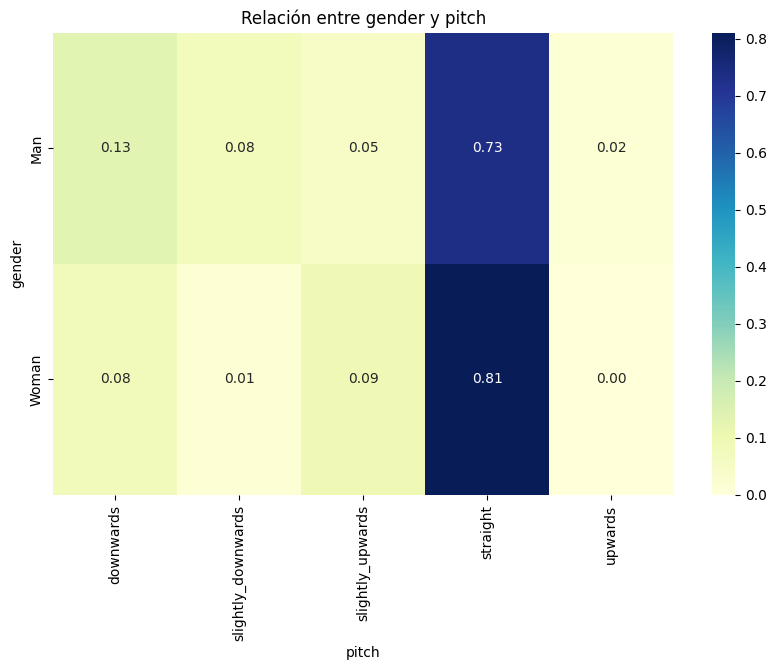

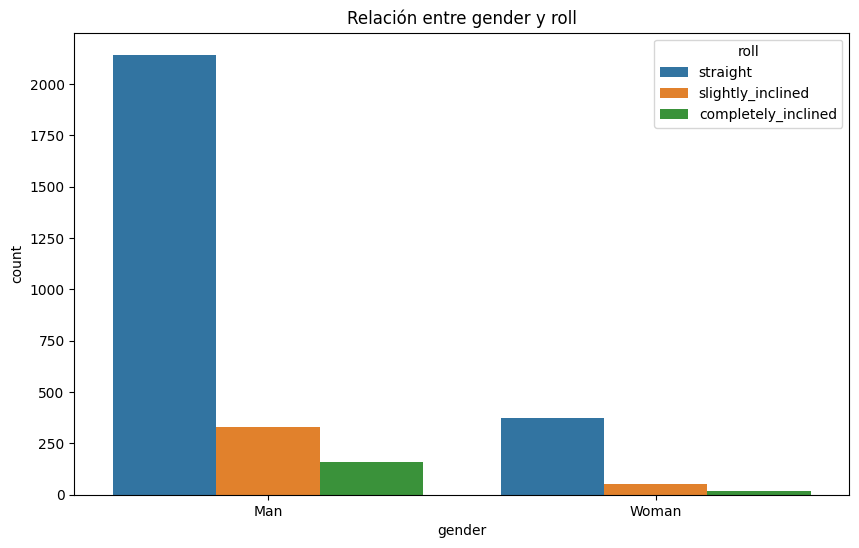

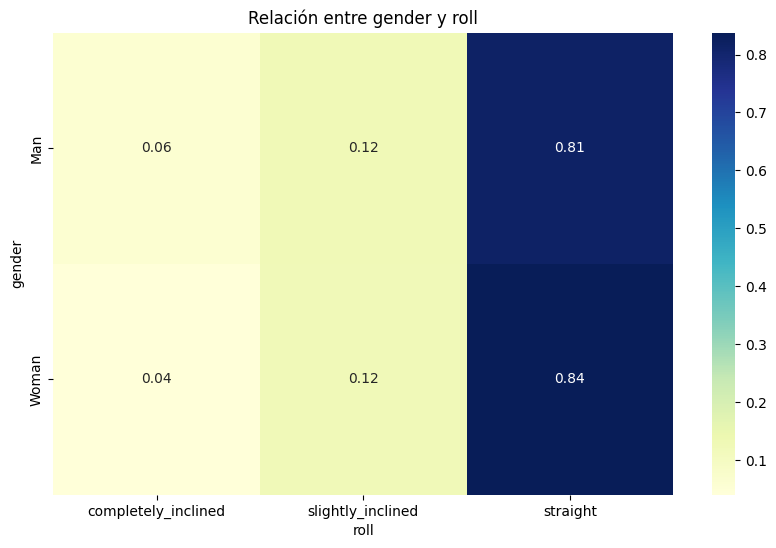

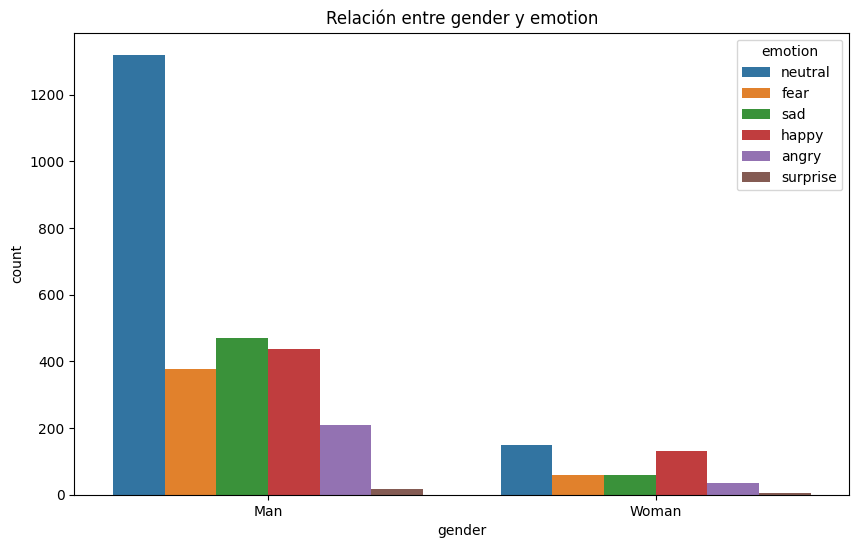

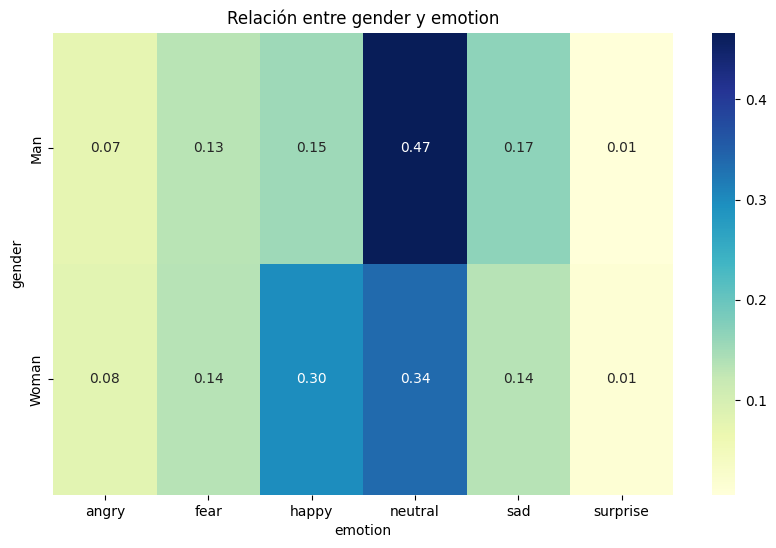

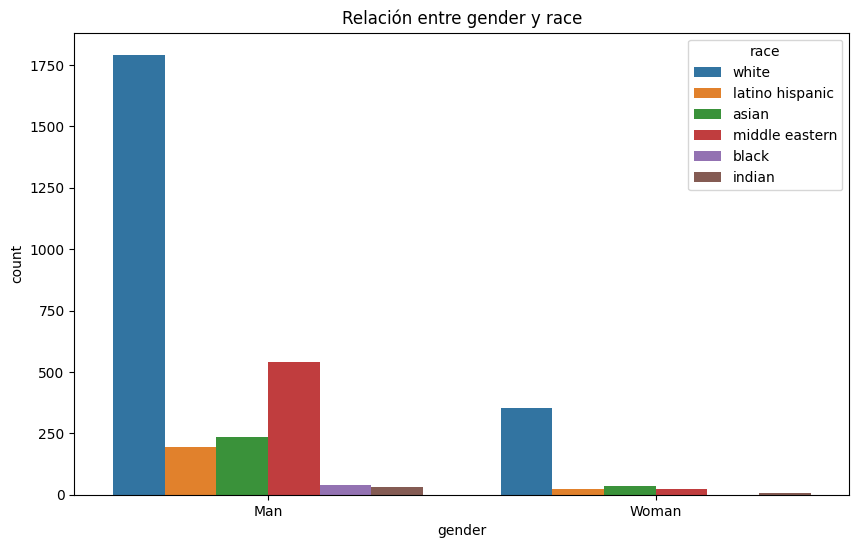

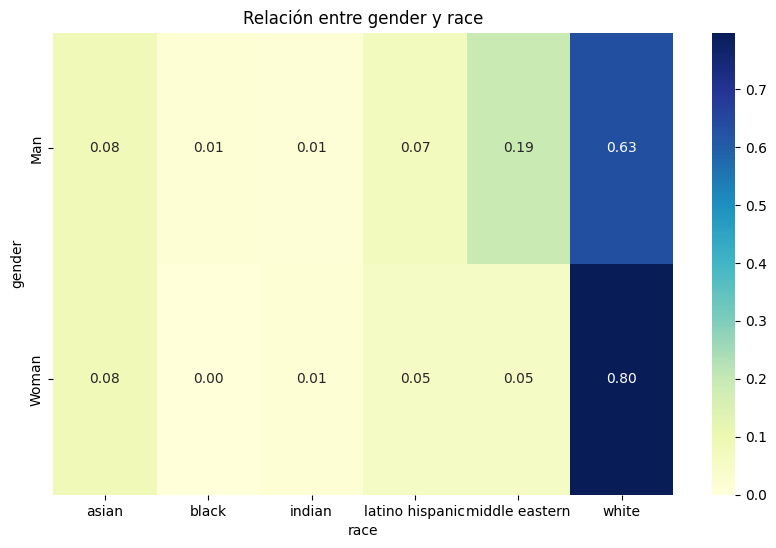

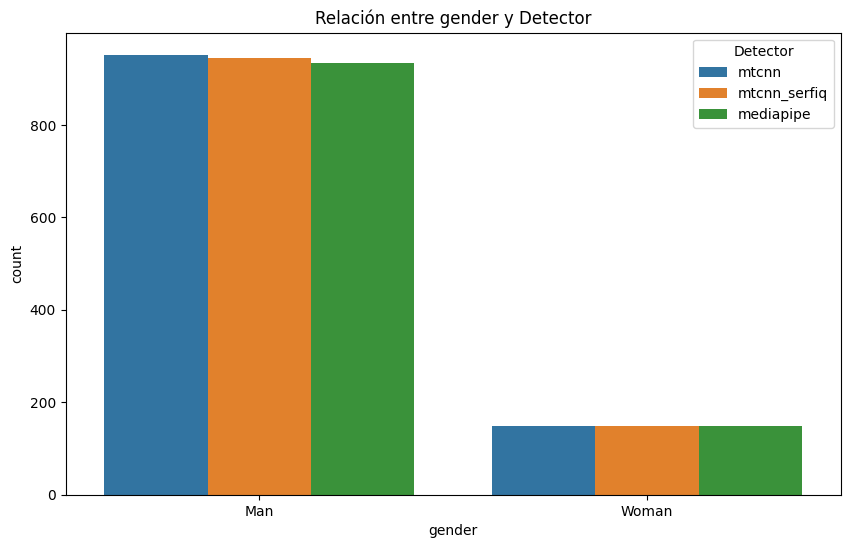

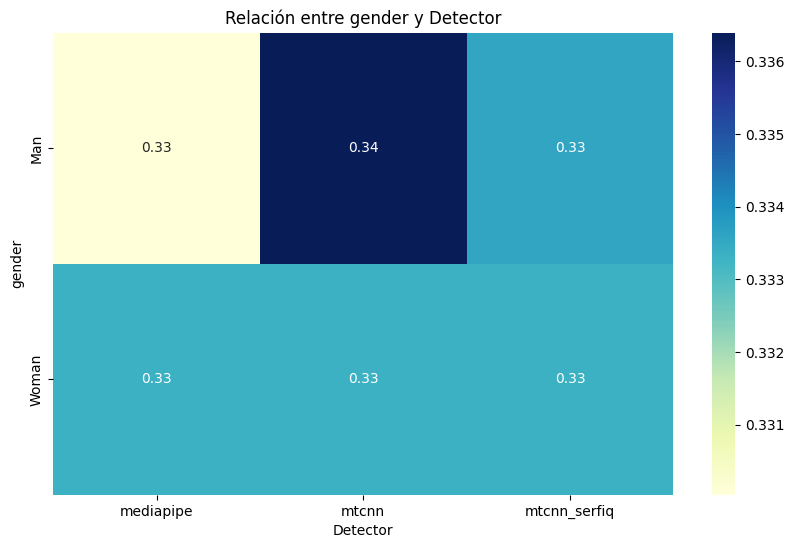

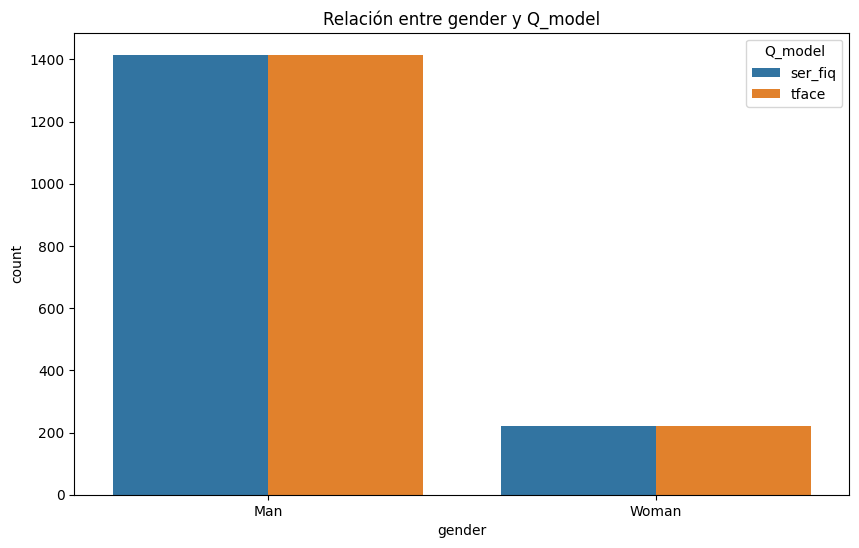

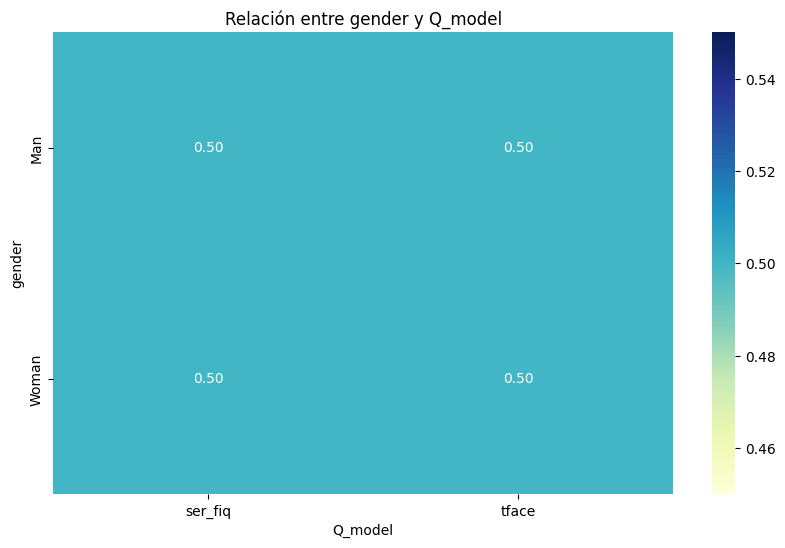

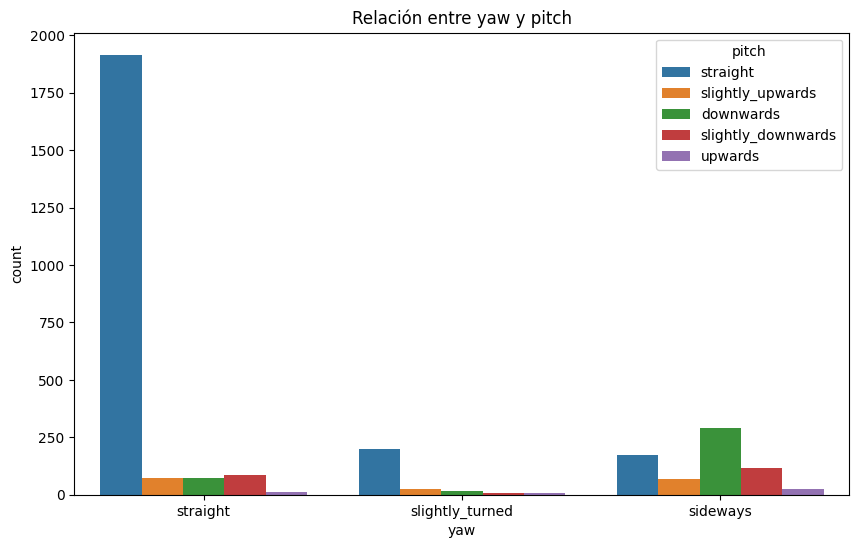

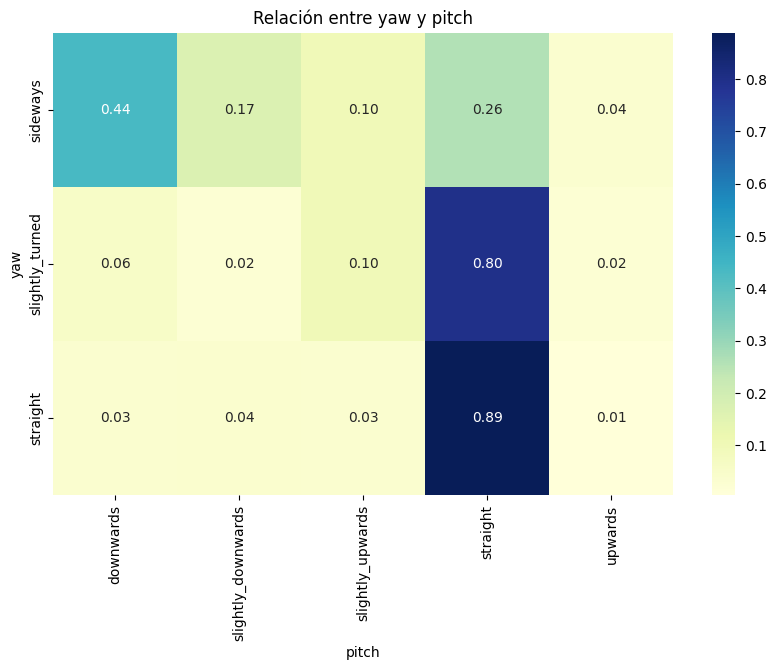

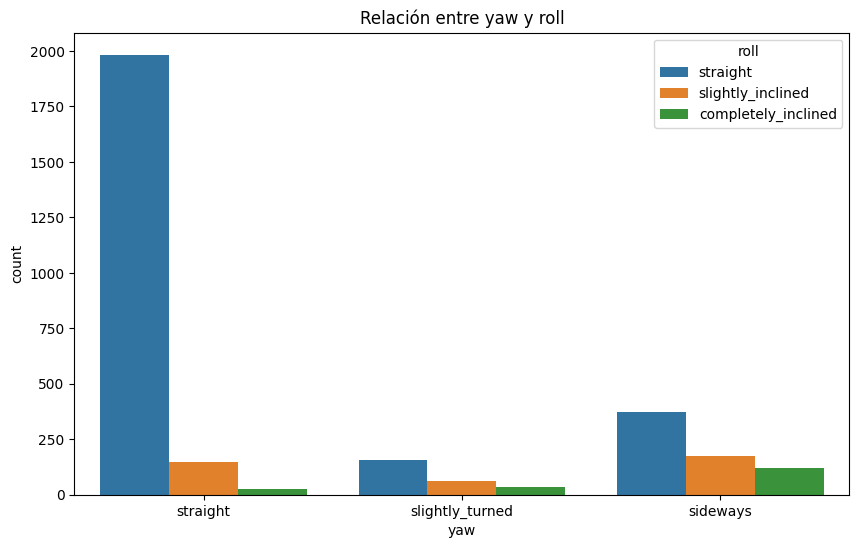

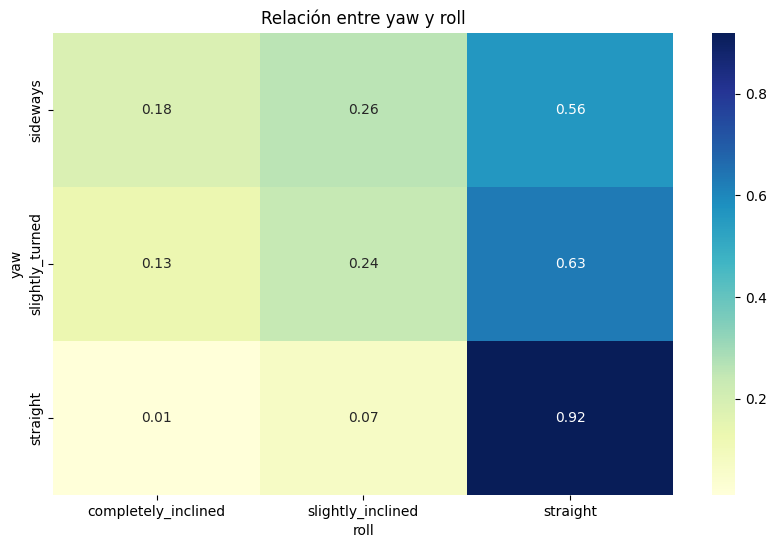

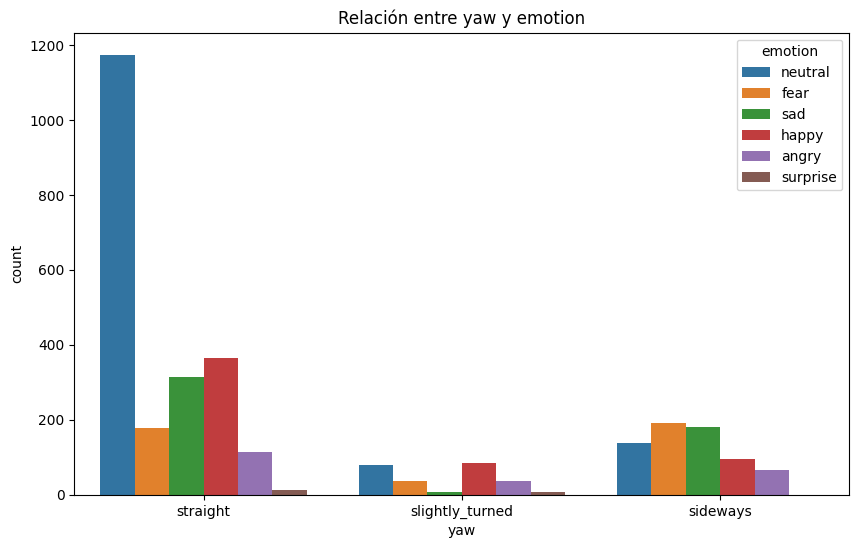

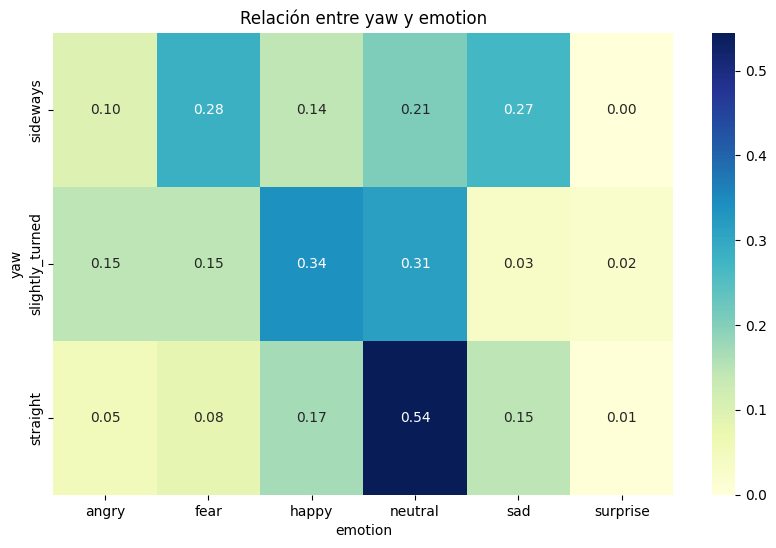

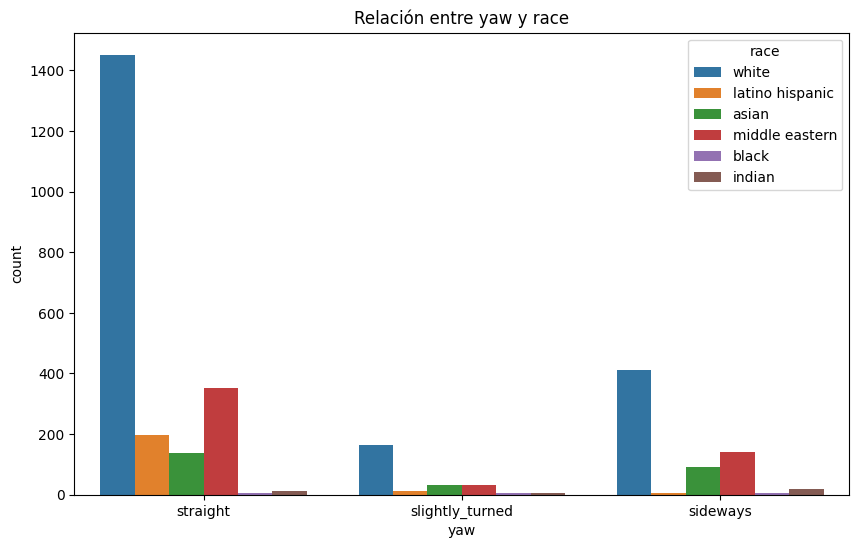

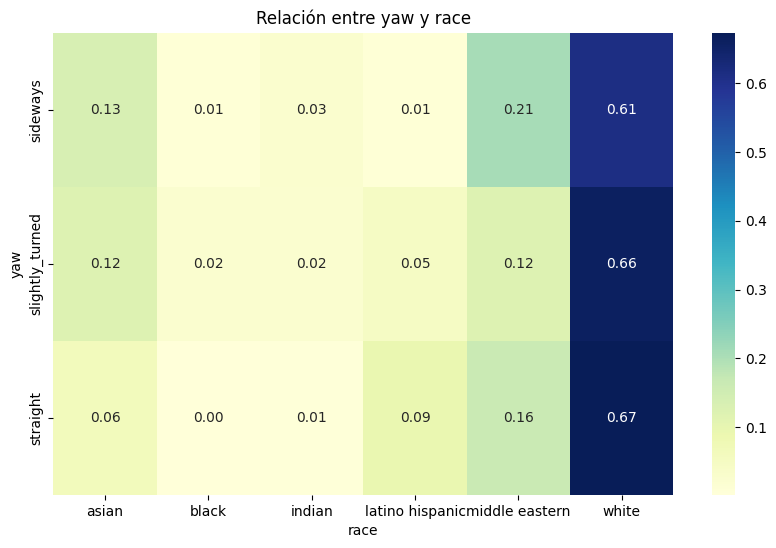

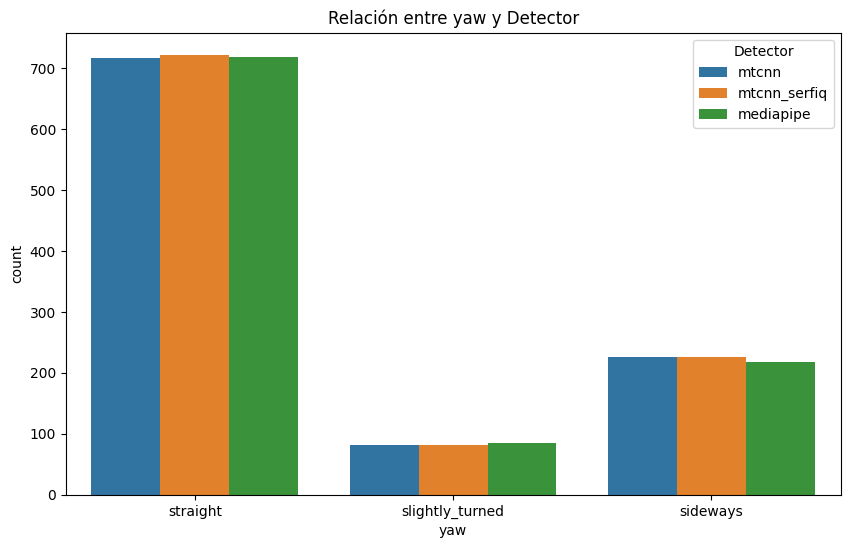

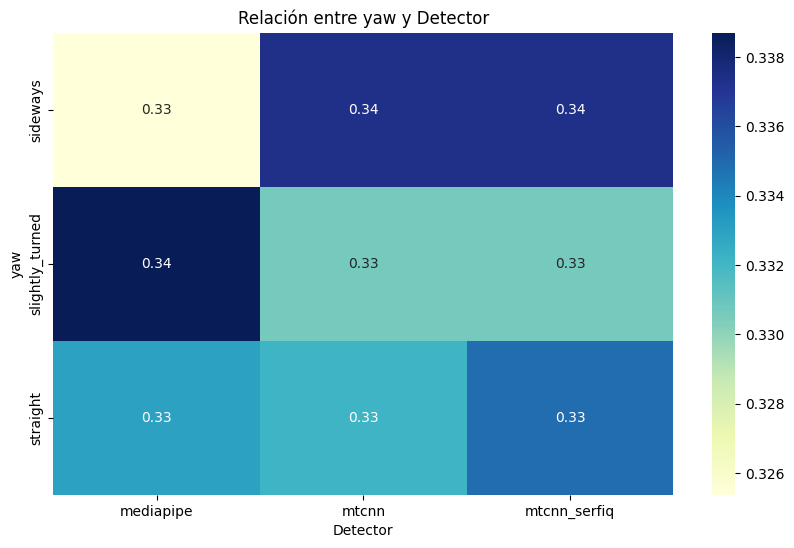

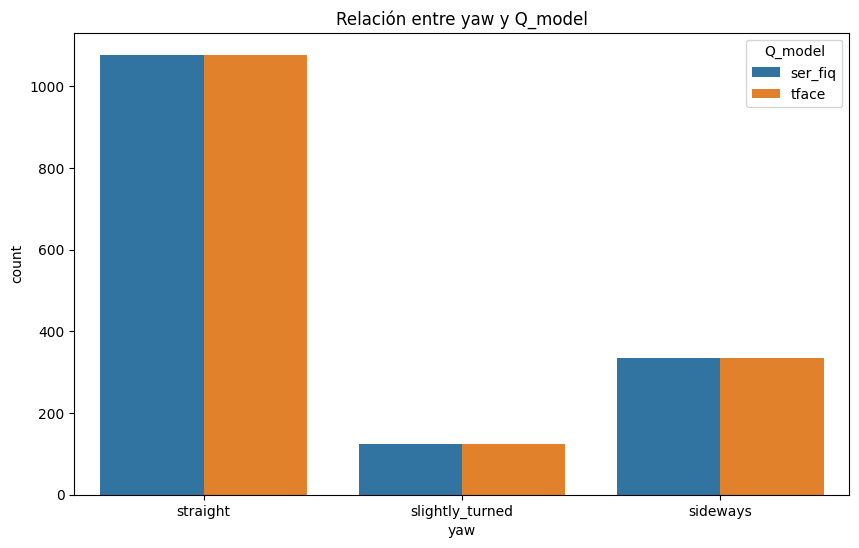

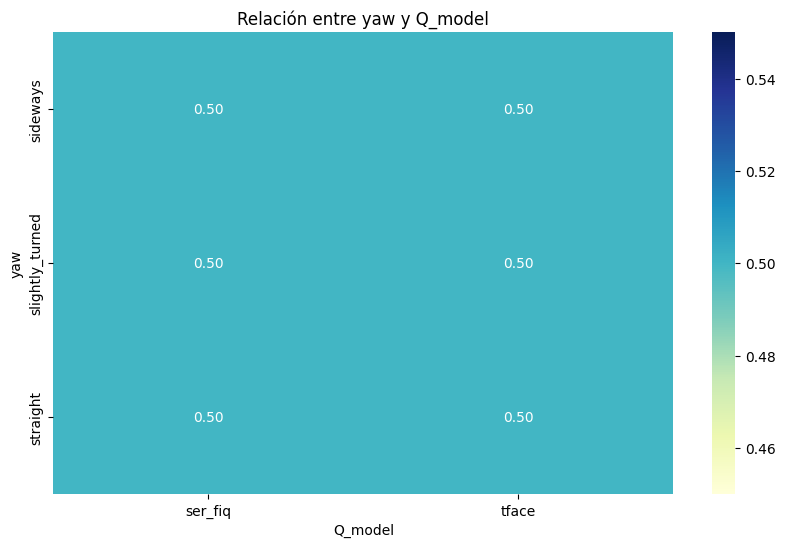

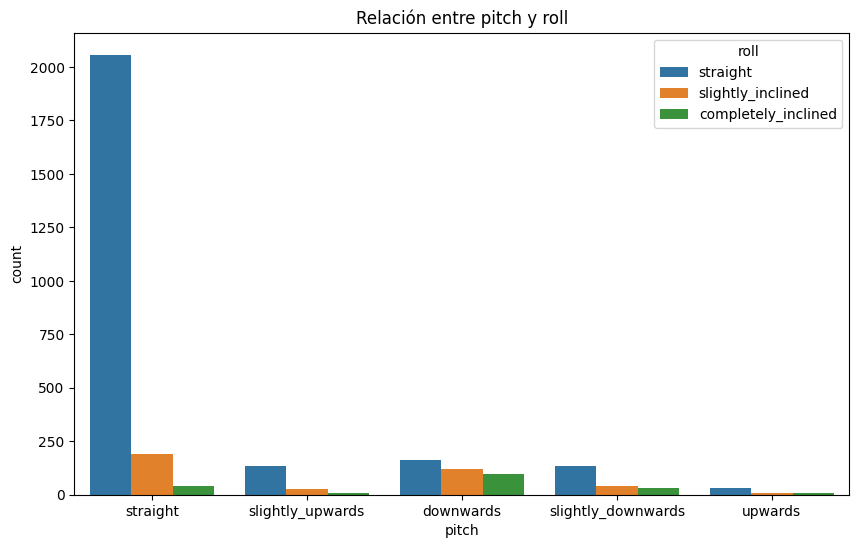

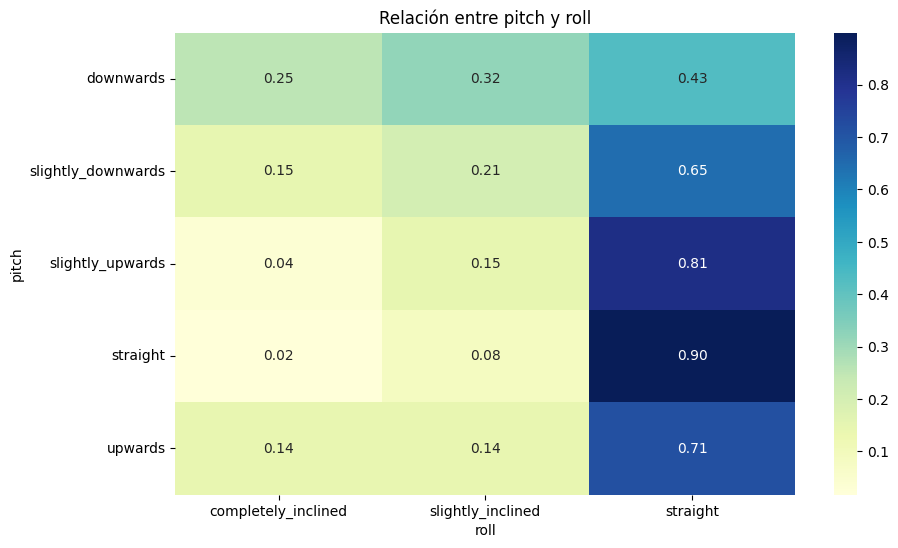

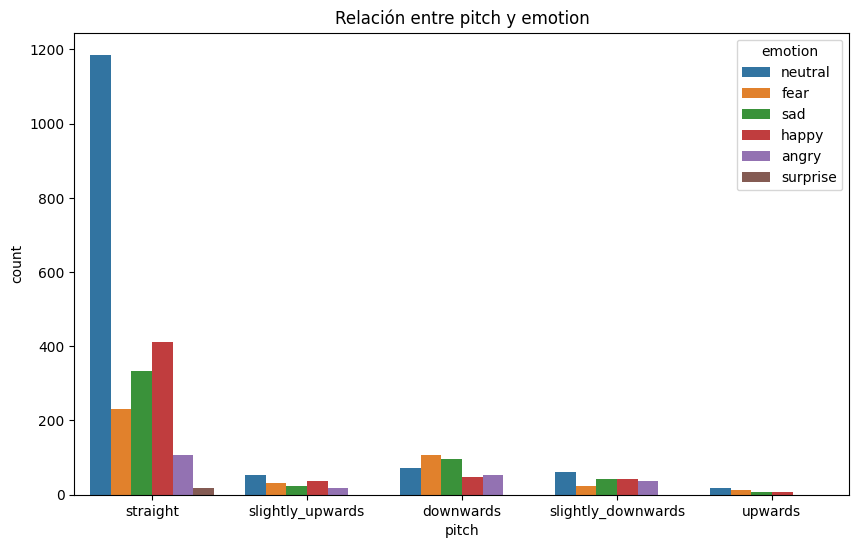

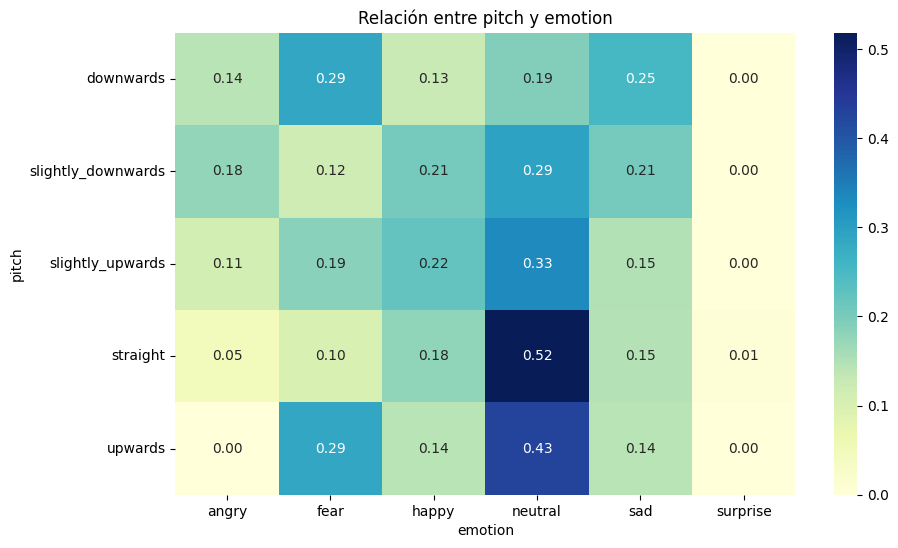

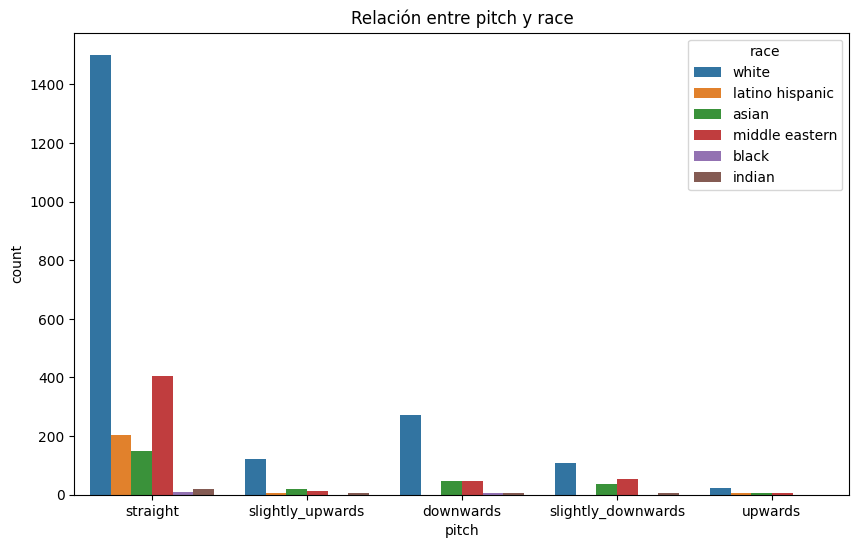

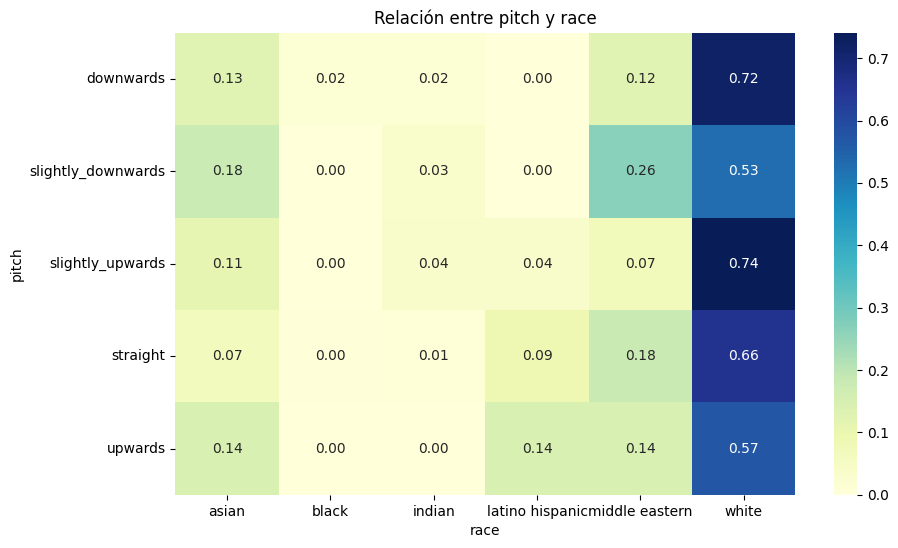

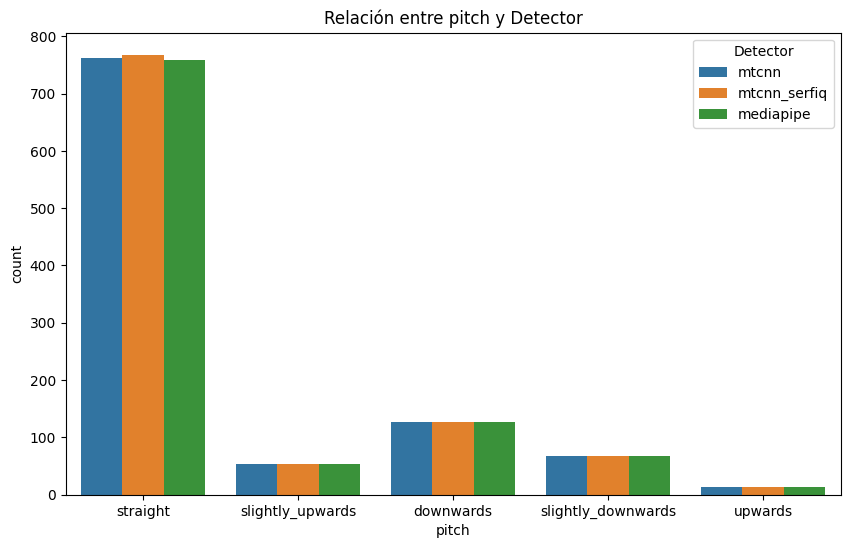

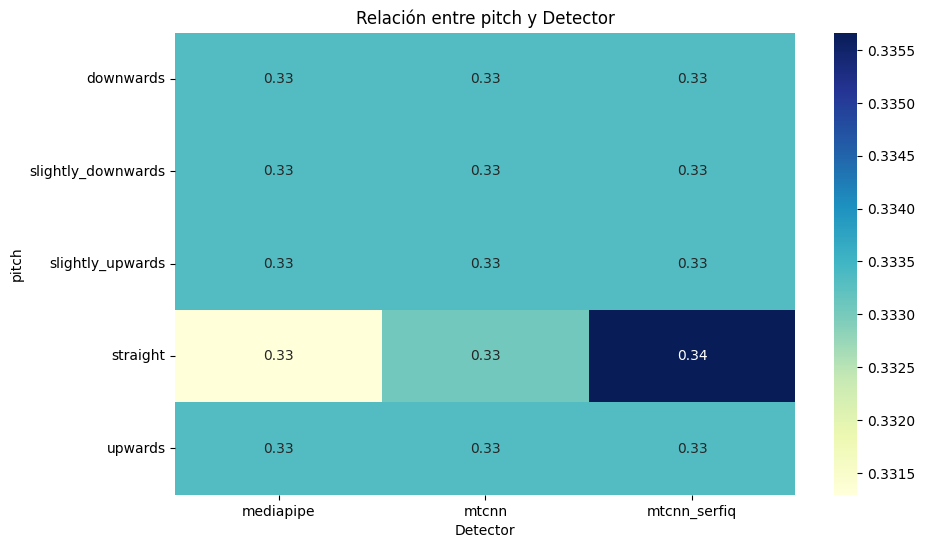

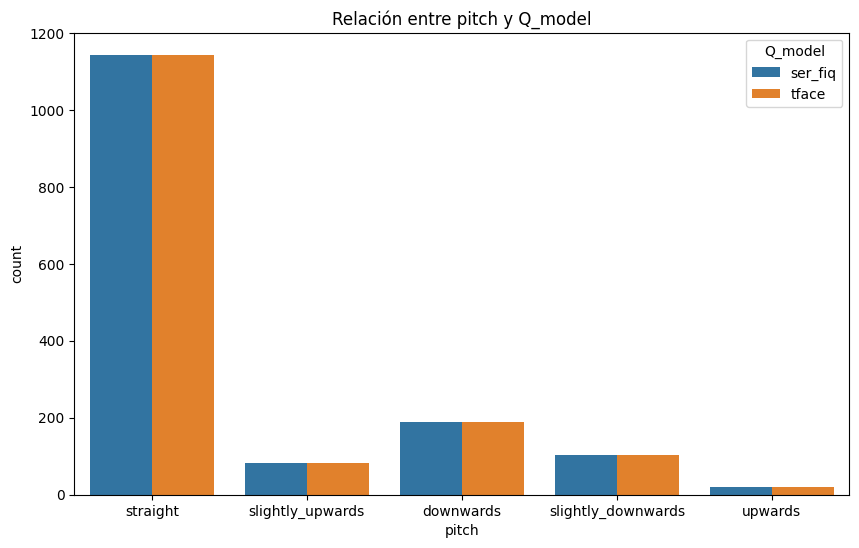

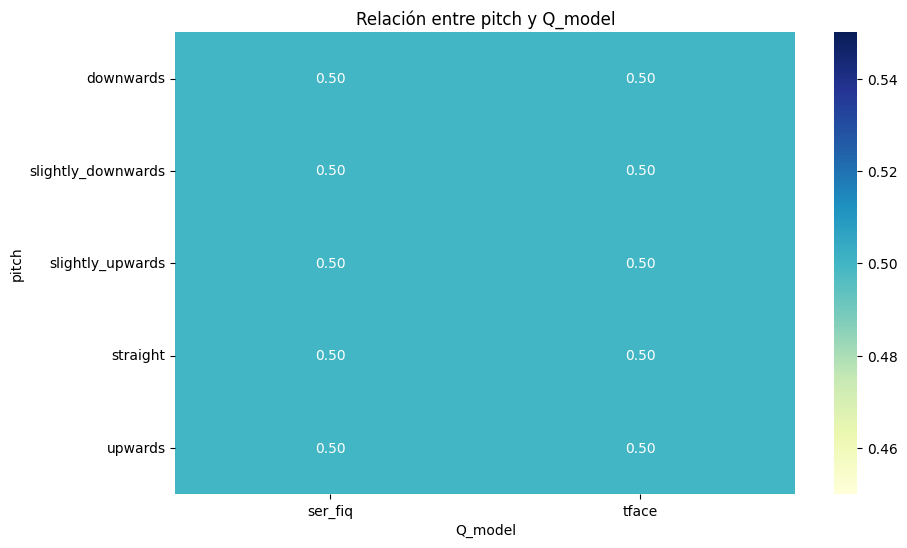

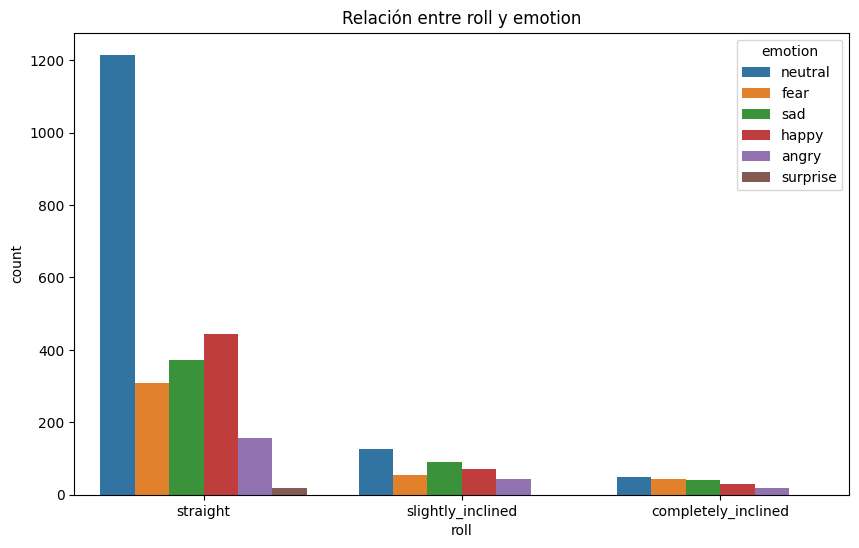

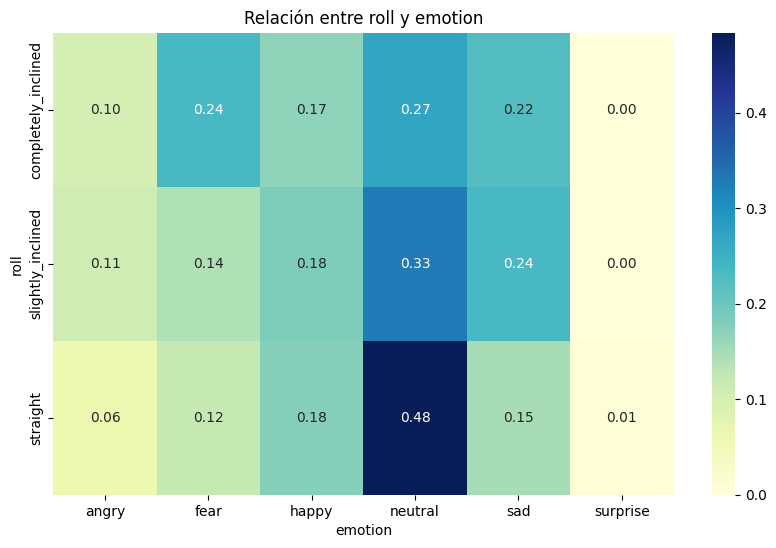

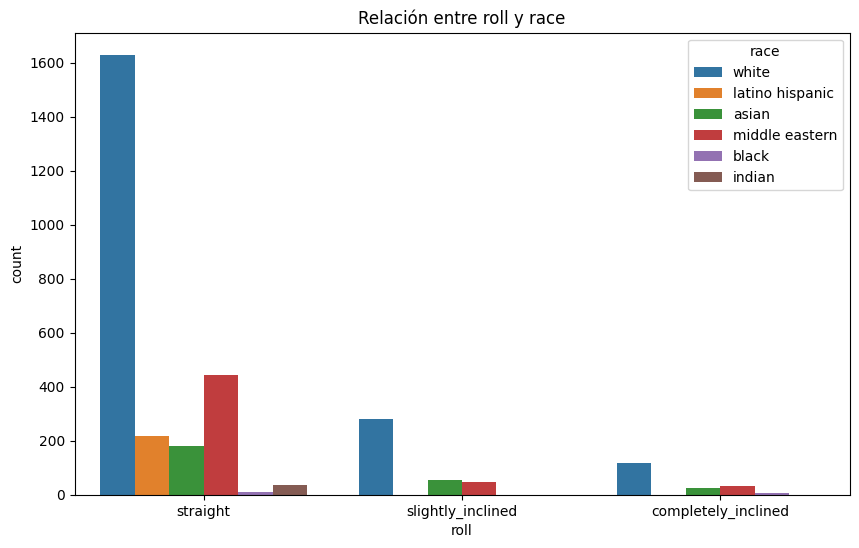

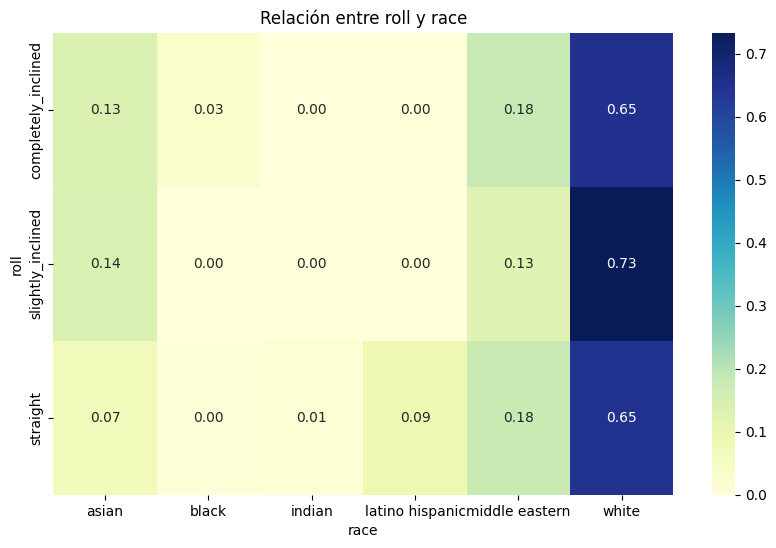

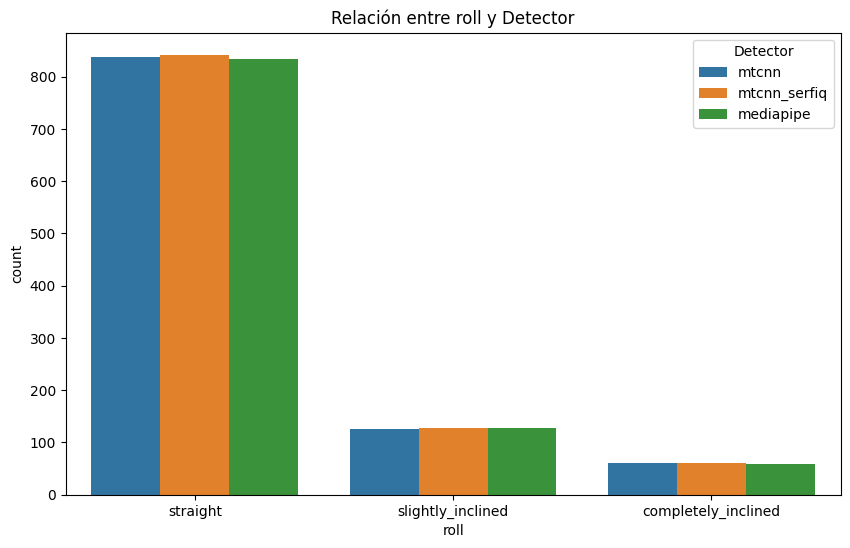

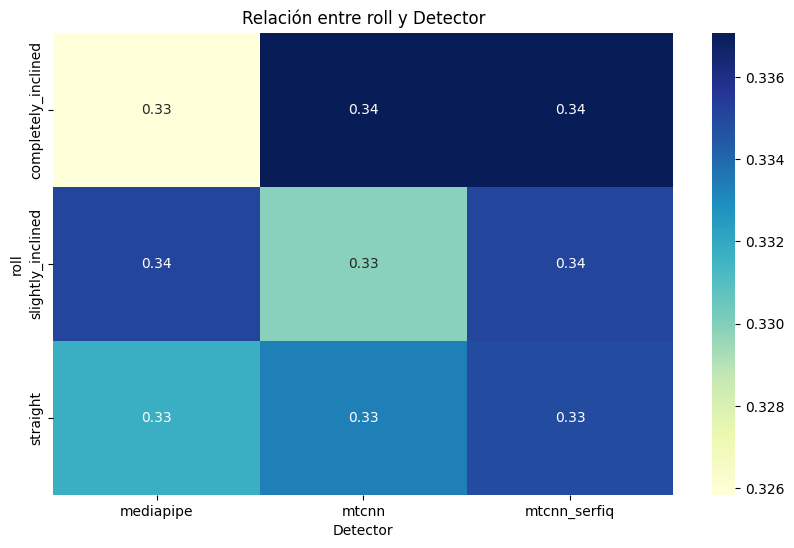

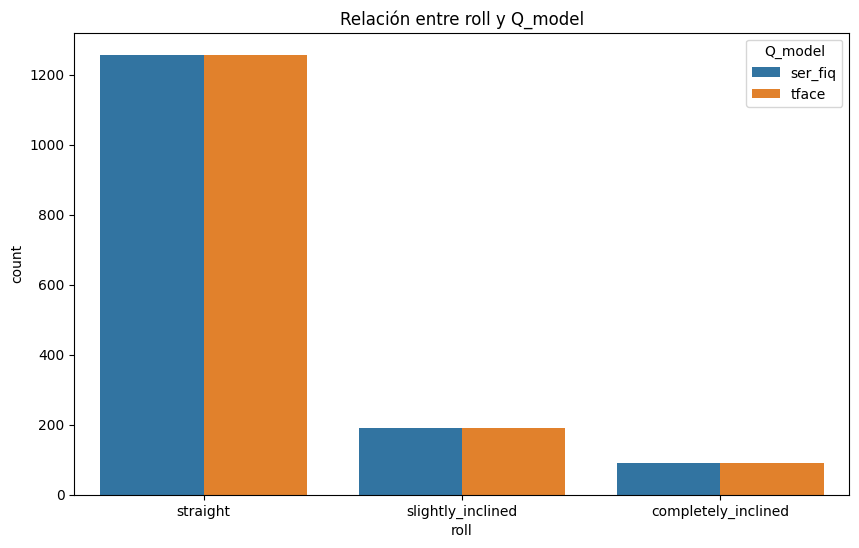

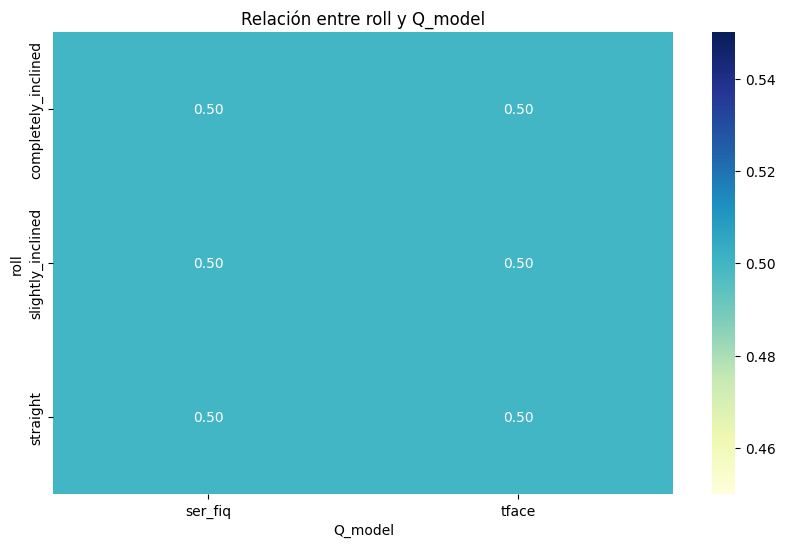

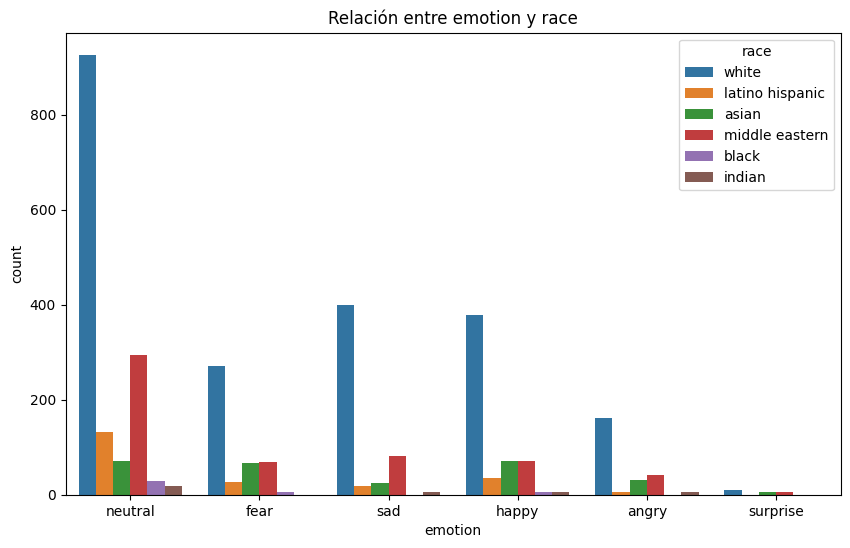

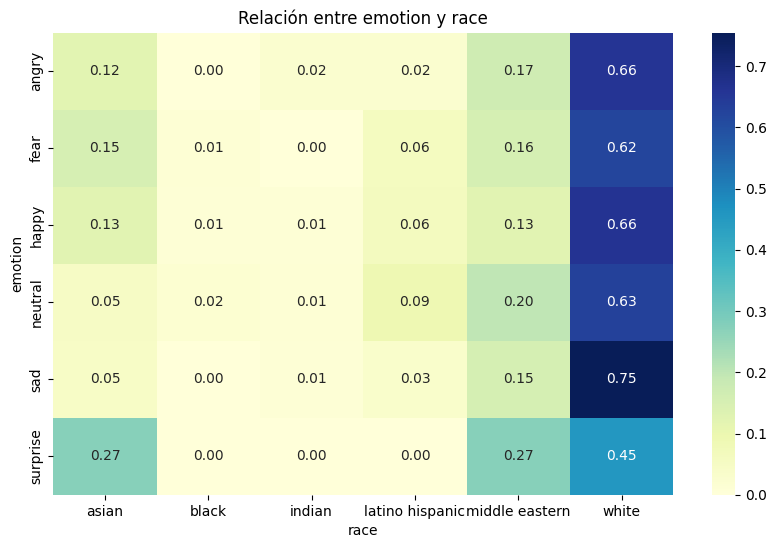

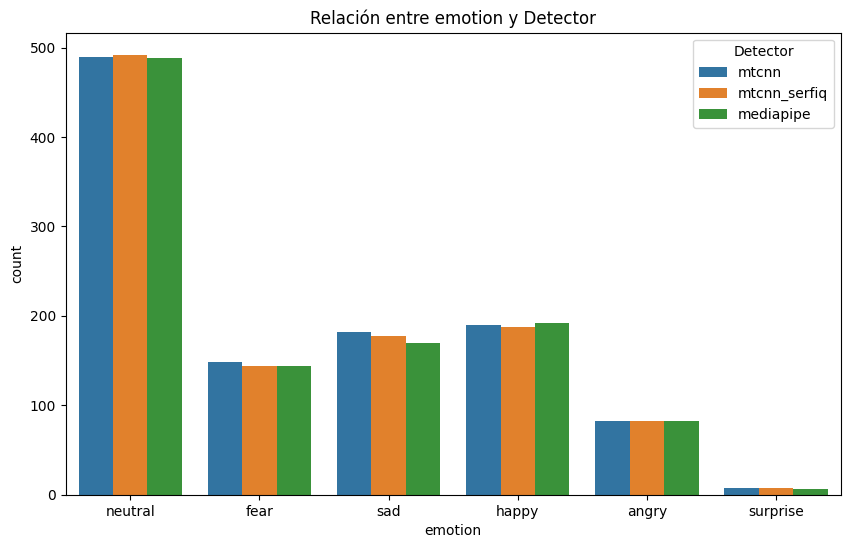

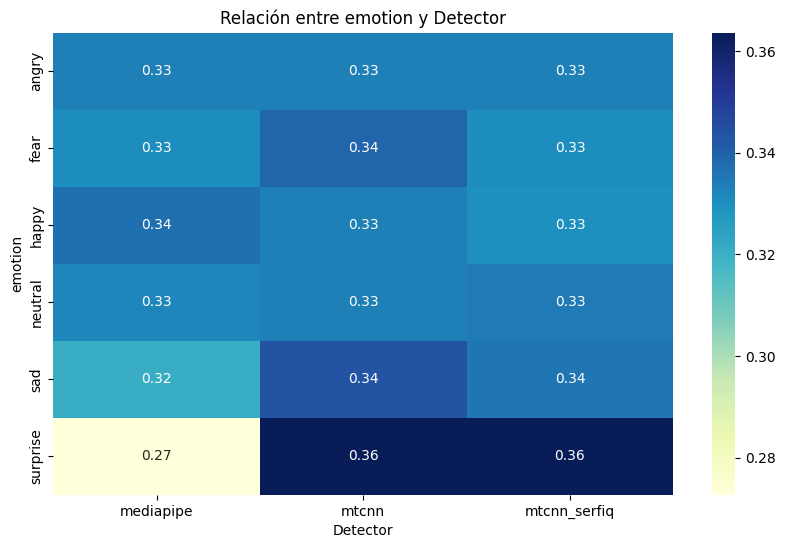

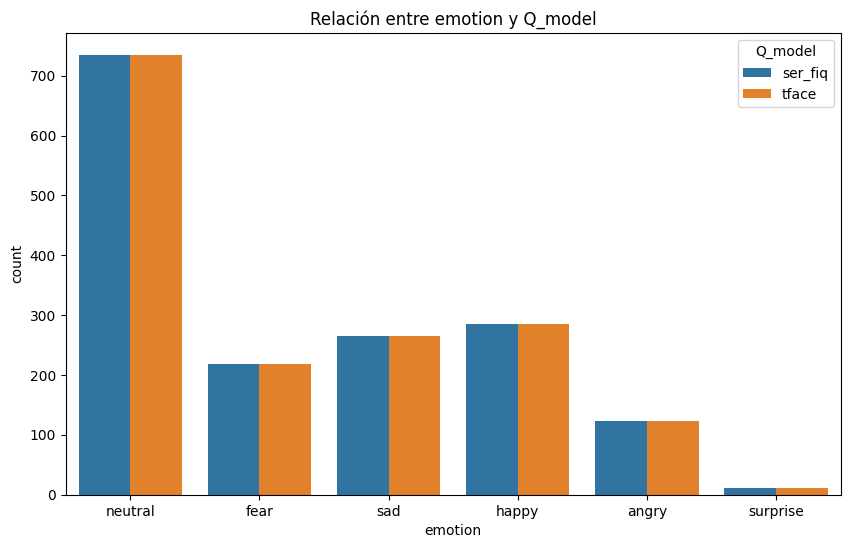

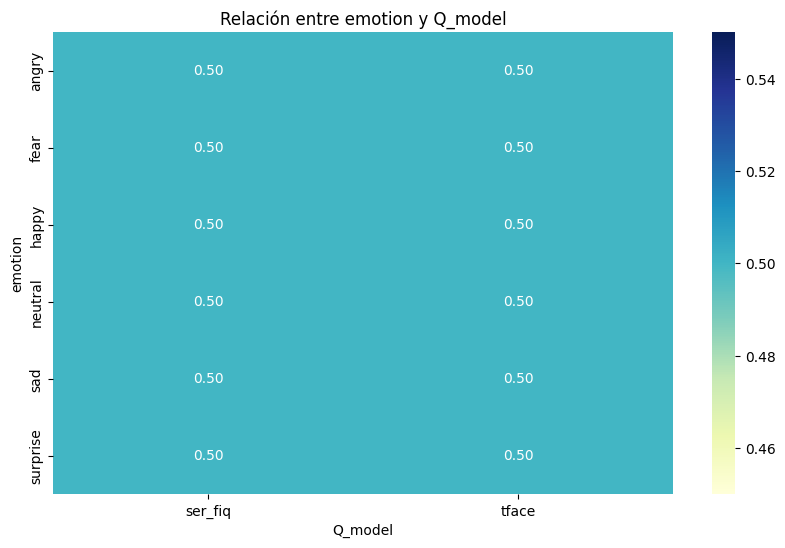

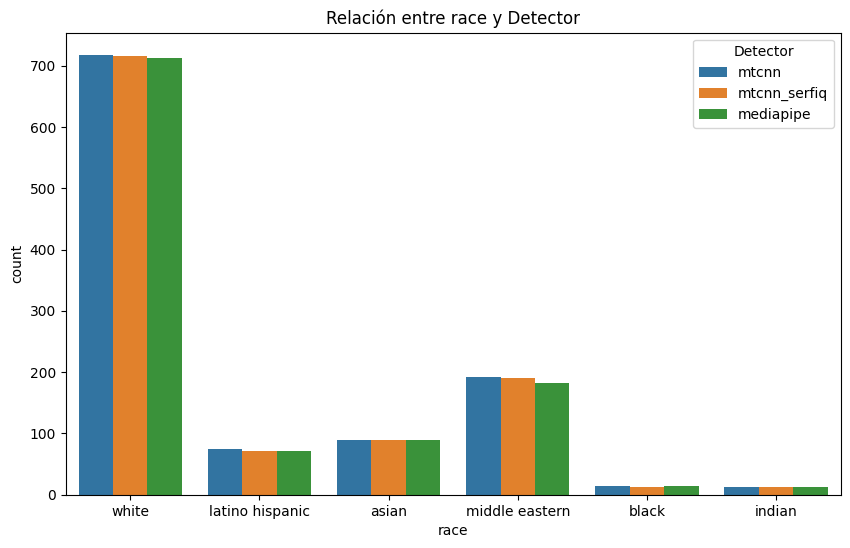

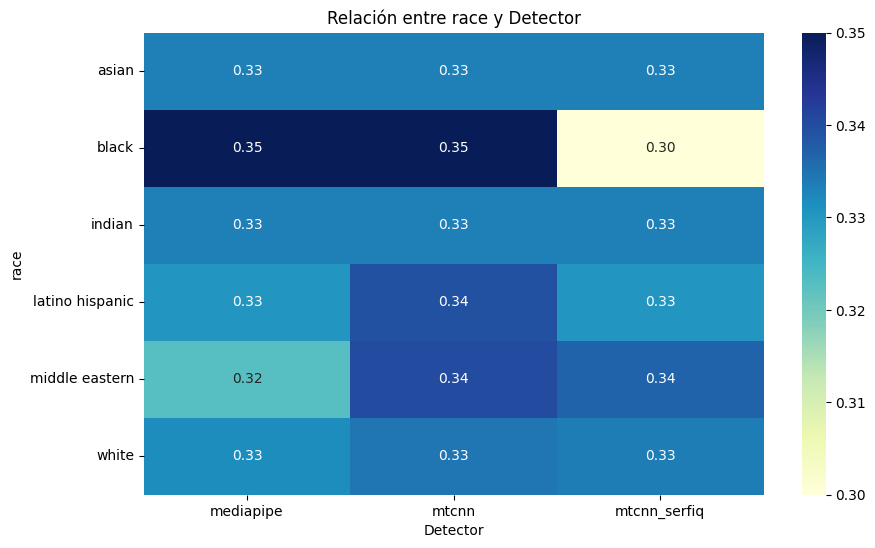

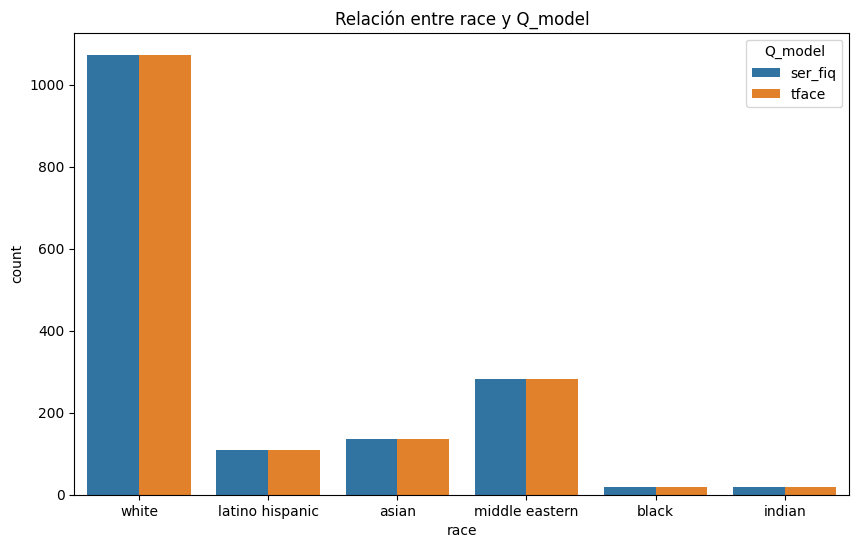

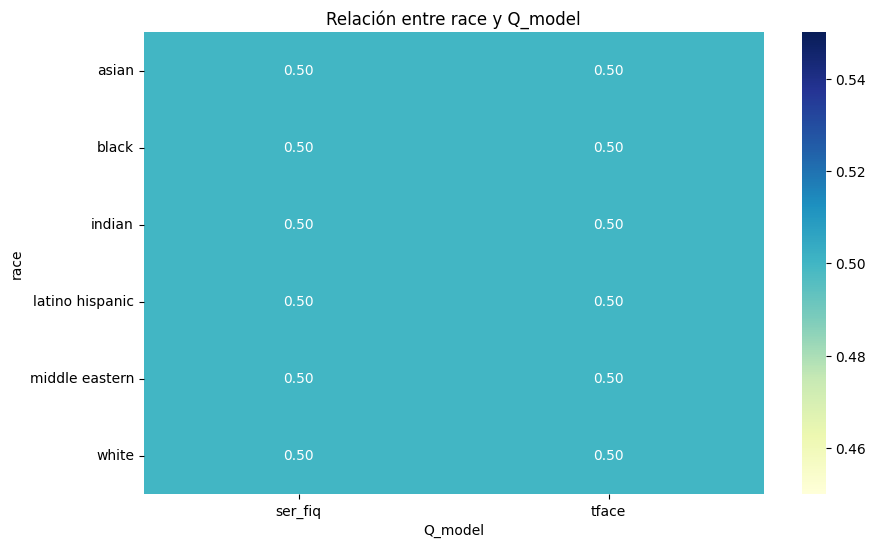

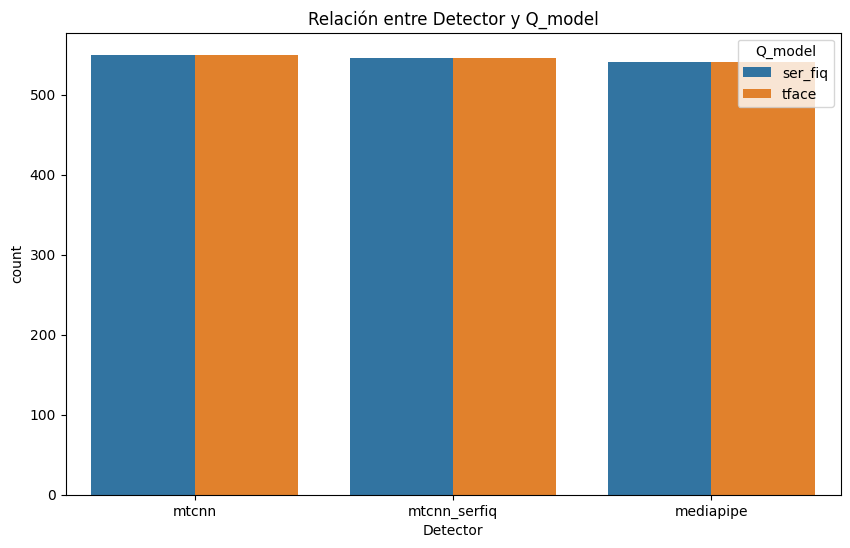

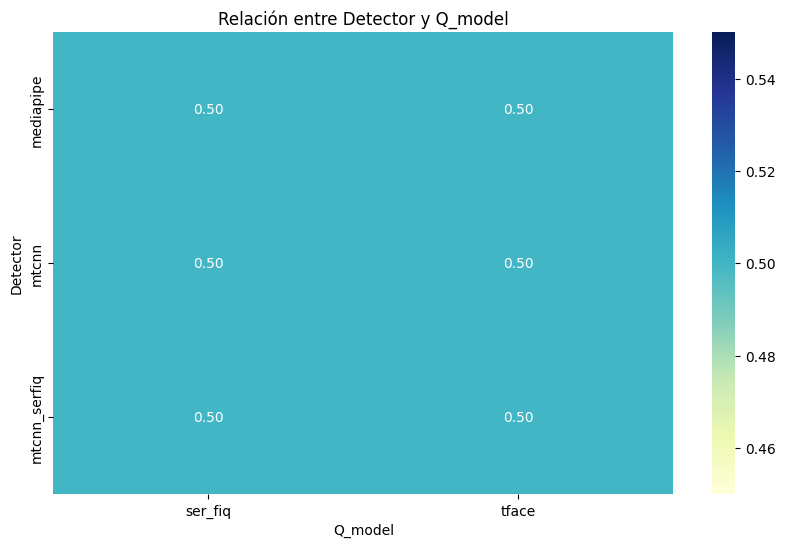

In [20]:




# Visualizar la relación entre cada par de variables utilizando gráficos de conteo (countplots) y mapas de calor (heatmaps)
for i, var1 in enumerate(variables):
    for j, var2 in enumerate(variables):
        if i < j:
            # Gráfico de conteo (countplot)
            plt.figure(figsize=(10, 6))
            sns.countplot(x=var1, hue=var2, data=df2)
            plt.title(f'Relación entre {var1} y {var2}')
            plt.show()

            # Mapa de calor (heatmap)
            contingency_table = pd.crosstab(df_plot[var1], df_plot[var2])
            normalized_table = contingency_table / contingency_table.sum(axis=1)[:, np.newaxis]
            plt.figure(figsize=(10, 6))
            sns.heatmap(normalized_table, annot=True, fmt=".2f", cmap="YlGnBu")
            plt.title(f'Relación entre {var1} y {var2}')
            plt.show()


In [165]:
# Asumiendo que 'df2' es tu DataFrame
variables = ['Detector', 'Q_model', 'gender']

# Transformar el DataFrame en formato "long"
df_long = df2.melt(
    id_vars="Q_group",
    value_vars=variables,
    var_name="variable",
    value_name="value",
)


In [166]:
df_long

,Q_group,variable,value
0,High,Detector,mtcnn
1,Very high,Detector,mtcnn
2,Medium,Detector,mtcnn
3,High,Detector,mtcnn
4,Low,Detector,mtcnn
...,...,...,...
9817,Low,gender,Woman
9818,Low,gender,Man
9819,Medium,gender,Woman
9820,Low,gender,Woman


In [167]:


# Crear una gráfica facetada de conteo (countplot)
g = sns.catplot(
    data=df2,
    x="Q_group",
    kind="count",
    col_order=sorted(df2["Q_group"].unique()),
    row="variable",
    hue="value",
    col_wrap=1,
    sharey=False,
    col="Q_group",
    height=4,
    aspect=2,
    margin_titles=True,
)

# Ajustar los títulos de las gráficas
g.set_titles(row_template="{row_name}", col_template="{col_name}")

# Mostrar la gráfica
plt.show()

ValueError: Could not interpret input 'value'

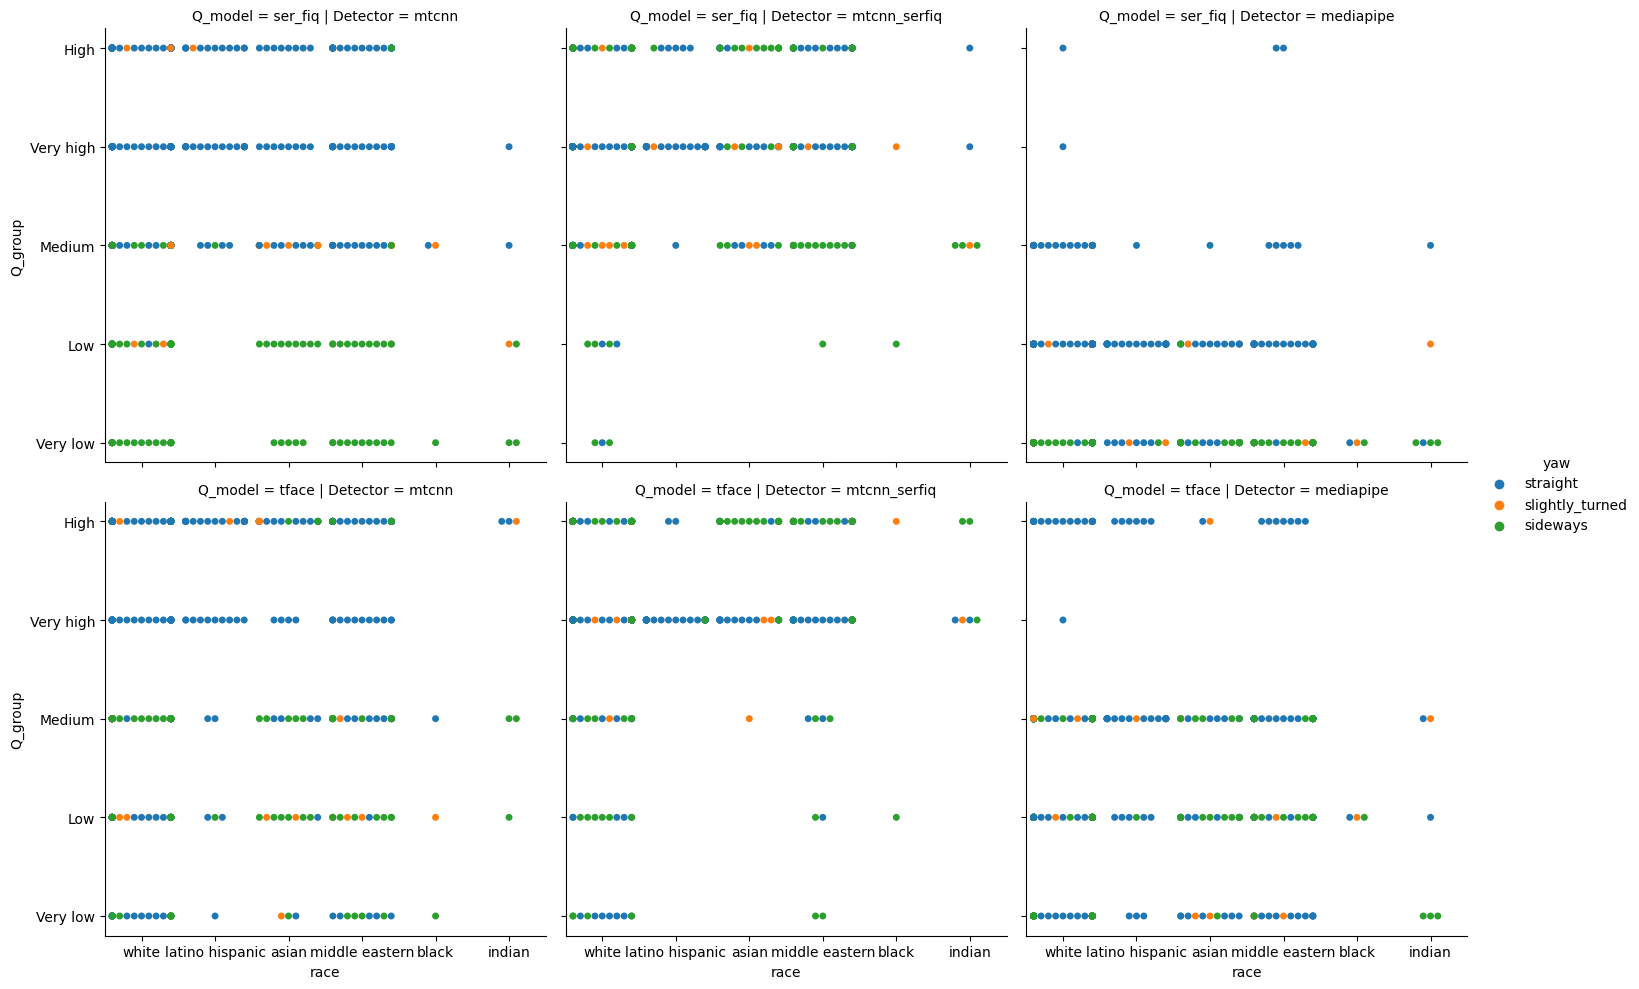

In [30]:
g = sns.catplot(y='Q_group',x= 'race', row= "Q_model",col='Detector',hue='yaw',kind = 'swarm', data= df_plot)
plt.show()

In [171]:
import plotly.express as px

fig = px.treemap(df_plot, path=['Q_group', 'Q_model', 'Detector', 'gender'], title="Mosaic Plot")
fig.show()

In [57]:


# Tabla de contingencia para Quality_group y Detector
contingency_table_detector = pd.crosstab(df_plot['Q_group'], df_plot['Detector'])

# Tabla de contingencia para Quality_group y Quality_model
contingency_table_quality_model = pd.crosstab(df_plot['Q_group'], df_plot['Q_model'])

# Tabla de contingencia para Quality_group y yaw
contingency_table_yaw = pd.crosstab(df_plot['Q_group'], df_plot['yaw'])

# Tabla de contingencia para Quality_group y gender
contingency_table_gender = pd.crosstab(df_plot['Q_group'], df_plot['gender'])


# Tabla de contingencia para Quality_group y emotion
contingency_table_emotion = pd.crosstab(df_plot['Q_group'], df_plot['emotion'])

# Tabla de contingencia para Quality_group y race
contingency_table_race = pd.crosstab(df_plot['Q_group'], df_plot['race'])


In [58]:

def norm_table (df):
    for col in df.columns:
        df[col] = df[col]/sum(df[col])



In [59]:
norm_table(contingency_table_quality_model)
contingency_table_quality_model

Q_model,ser_fiq,tface
Q_group,,
High,0.156995,0.240073
Low,0.211973,0.176542
Medium,0.143555,0.215638
Very high,0.281002,0.240684
Very low,0.206475,0.127062


In [60]:
norm_table(contingency_table_detector)
contingency_table_detector

Detector,mediapipe,mtcnn,mtcnn_serfiq
Q_group,,,
High,0.036044,0.312727,0.244505
Low,0.390943,0.153636,0.040293
Medium,0.219039,0.210000,0.109890
Very high,0.001848,0.204545,0.574176
Very low,0.352126,0.119091,0.031136


In [61]:
norm_table(contingency_table_gender)
contingency_table_gender

gender,Man,Woman
Q_group,,
High,0.196466,0.211712
Low,0.195406,0.186937
Medium,0.176325,0.200450
Very high,0.256890,0.286036
Very low,0.174912,0.114865


In [62]:
norm_table(contingency_table_yaw)
contingency_table_yaw

yaw,sideways,slightly_turned,straight
Q_group,,,
High,0.158209,0.213710,0.224954
Low,0.229851,0.185484,0.173469
Medium,0.223881,0.233871,0.163729
Very high,0.088060,0.193548,0.346475
Very low,0.300000,0.173387,0.091373


In [63]:
norm_table(contingency_table_race)
contingency_table_race

race,asian,black,indian,latino hispanic,middle eastern,white
Q_group,,,,,,
High,0.259259,0.025,0.166667,0.211009,0.226950,0.185927
Low,0.196296,0.300,0.138889,0.165138,0.191489,0.196645
Medium,0.170370,0.125,0.277778,0.137615,0.179078,0.184529
Very high,0.177778,0.025,0.166667,0.422018,0.225177,0.270270
Very low,0.196296,0.525,0.250000,0.064220,0.177305,0.162628


In [64]:
norm_table(contingency_table_emotion)
contingency_table_emotion

emotion,angry,fear,happy,neutral,sad,surprise
Q_group,,,,,,
High,0.195122,0.199541,0.187719,0.204762,0.198113,0.090909
Low,0.182927,0.204128,0.180702,0.193878,0.201887,0.318182
Medium,0.219512,0.190367,0.221053,0.150340,0.188679,0.181818
Very high,0.191057,0.172018,0.273684,0.319048,0.190566,0.272727
Very low,0.211382,0.233945,0.136842,0.131973,0.220755,0.136364


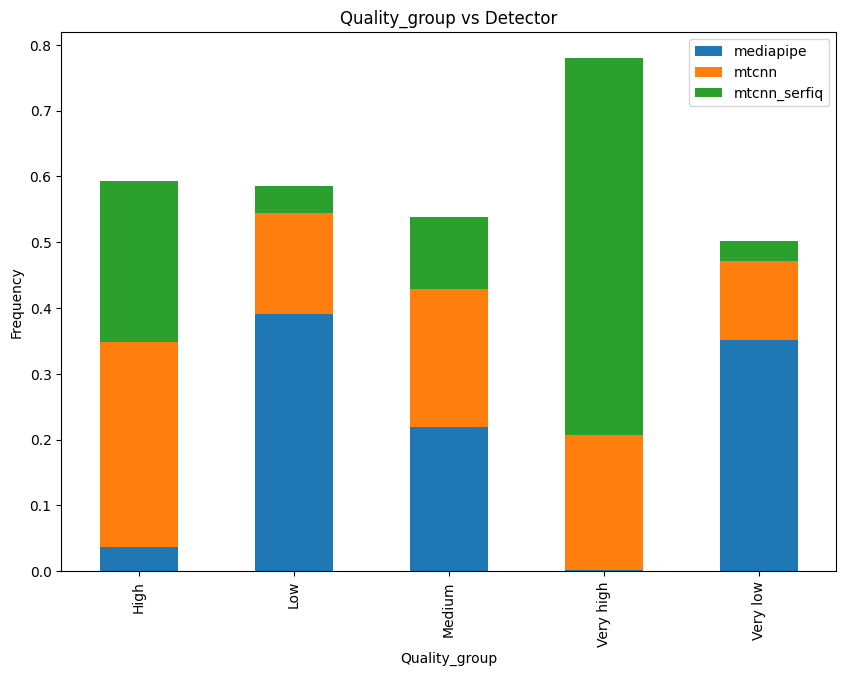

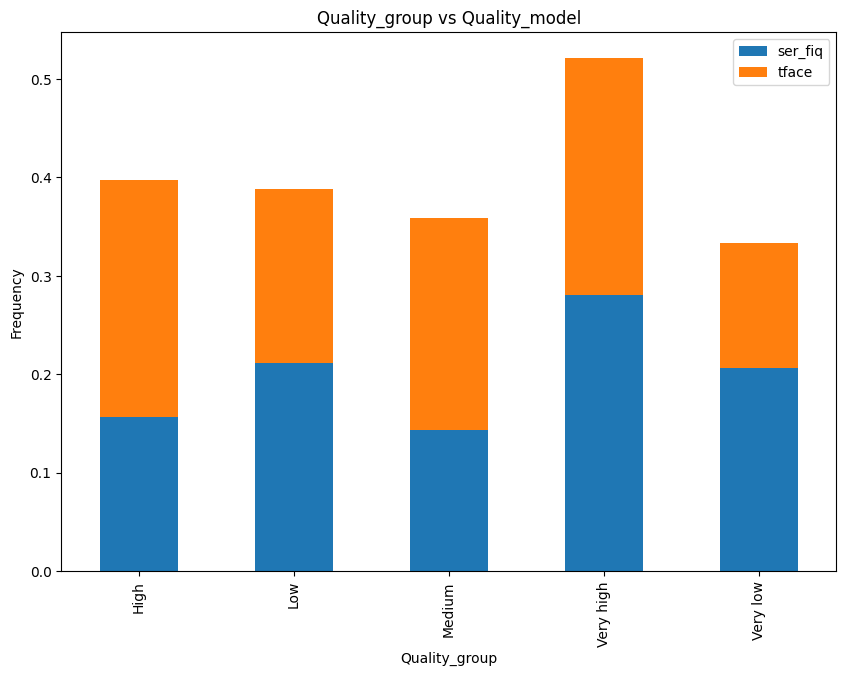

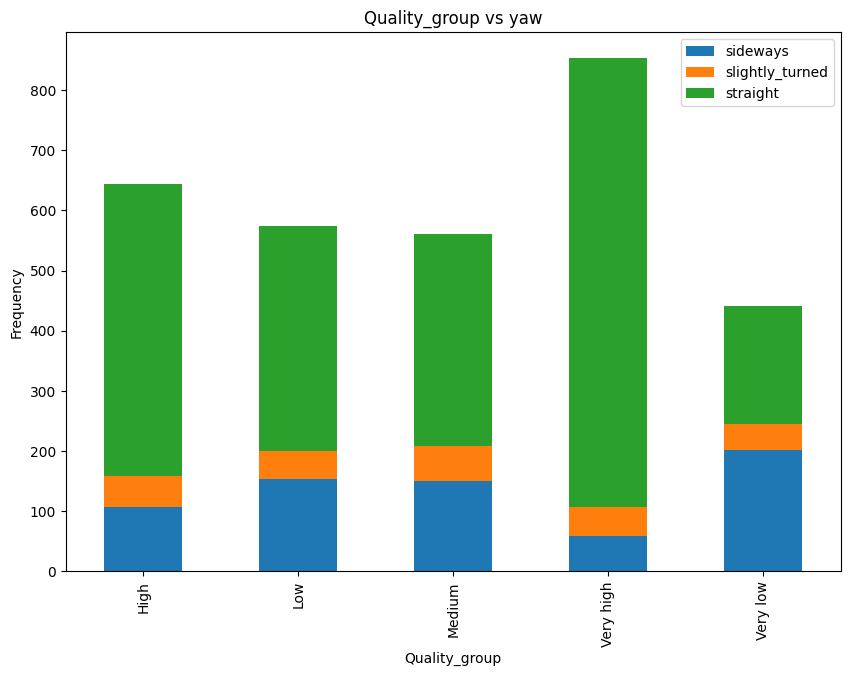

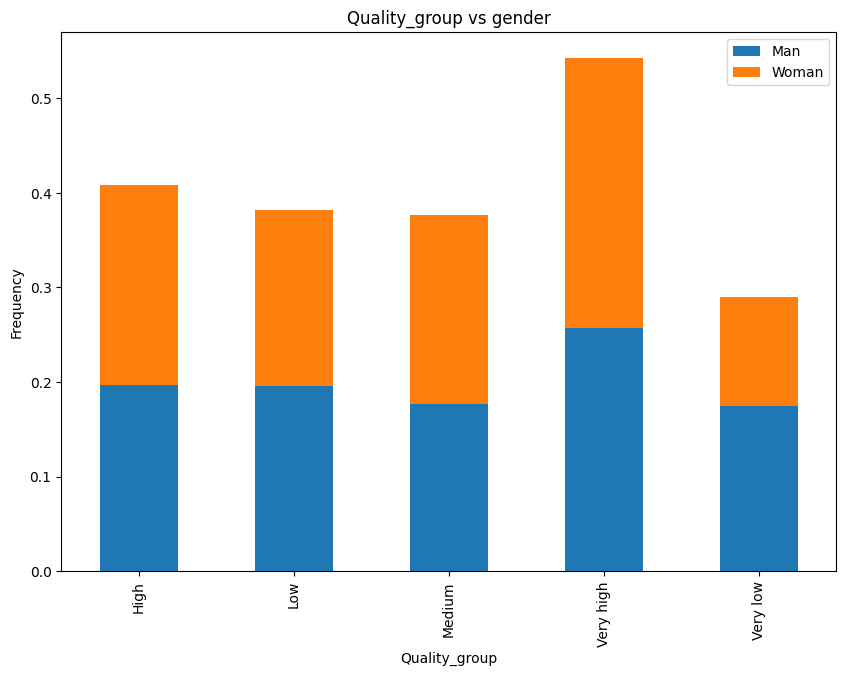

In [54]:
import matplotlib.pyplot as plt

def plot_stacked_bar(contingency_table, title, xlabel, ylabel):
    ax = contingency_table.plot(kind='bar', stacked=True, figsize=(10, 7))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.show()

plot_stacked_bar(contingency_table_detector, 'Quality_group vs Detector', 'Quality_group', 'Frequency')
plot_stacked_bar(contingency_table_quality_model, 'Quality_group vs Quality_model', 'Quality_group', 'Frequency')
plot_stacked_bar(contingency_table_yaw, 'Quality_group vs yaw', 'Quality_group', 'Frequency')
plot_stacked_bar(contingency_table_gender, 'Quality_group vs gender', 'Quality_group', 'Frequency')
